# Installing Libraries

In [1]:
!pip install torchmetrics scikit-learn medpy
!pip install monai
!pip install segmentation-models-pytorch
!pip install pretrained-backbones-unet

  Using cached timm-0.6.12-py3-none-any.whl.metadata (37 kB)
Using cached timm-0.6.12-py3-none-any.whl (549 kB)
  Attempting uninstall: timm
    Found existing installation: timm 1.0.14
    Uninstalling timm-1.0.14:
      Successfully uninstalled timm-1.0.14
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
segmentation-models-pytorch 0.4.0 requires timm>=0.9, but you have timm 0.6.12 which is incompatible.


In [2]:
!pip uninstall timm
!pip install timm

Found existing installation: timm 0.6.12
Uninstalling timm-0.6.12:
  Would remove:
    /usr/local/lib/python3.11/dist-packages/timm-0.6.12.dist-info/*
    /usr/local/lib/python3.11/dist-packages/timm/*
Proceed (Y/n)? y
  Successfully uninstalled timm-0.6.12
  Using cached timm-1.0.14-py3-none-any.whl.metadata (50 kB)
Using cached timm-1.0.14-py3-none-any.whl (2.4 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pretrained-backbones-unet 0.0.1 requires timm==0.6.12, but you have timm 1.0.14 which is incompatible.


In [3]:
!pip show pretrained-backbones-unet

Name: pretrained-backbones-unet
Version: 0.0.1
Summary: A small example package
Home-page: https://github.com/mberkay0/pretrained-backbones-unet
Author: Berkay Mayali
Author-email: Example Author <author@example.com>
License: MIT
Location: /usr/local/lib/python3.11/dist-packages
Requires: timm, torch
Required-by: 


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Our imports

In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np
import torchvision.transforms.functional as F
from tqdm import tqdm  # for progress bars
from backbones_unet.model.unet import Unet
# import segmentation_models_pytorch as smp
from torchvision.transforms import InterpolationMode
import random
import matplotlib.pyplot as plt
#cudnn module from PyTorch, which provides access to NVIDIA's CUDA Deep Neural Network library (cuDNN). cuDNN is a library of highly optimized primitives for deep learning.
import torch.backends.cudnn as cudnn
import backbones_unet
from torch.amp import autocast, GradScaler  # Import from torch.amp
from tabulate import tabulate

#Setting Up Reproducibility and CUDA Environment

In [6]:
# Set seed for reproducibility
SEED = 42
#This line sets the seed for Python's built-in random module.
random.seed(SEED)
#This line sets the seed for NumPy's random number generator.
np.random.seed(SEED)
#This line sets the seed for PyTorch's random number generator for the CPU.
torch.manual_seed(SEED)
if torch.cuda.is_available():
#sets the seed for PyTorch's random number generator for all available GPUs.
    torch.cuda.manual_seed_all(SEED)

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

 # Defines essential parameters for your model training , specifies the locations of your data, determines the size of your datasets, and sets up a location to save your trained model.

In [7]:
########################################
# Network and Training Parameters      #
########################################
IMG_SIZE = 256
NBEPOCHS = 100
BATCH_SIZE = 64
NBPATIENCE_EPOCHS = 200
NUM_CLASSES = 4 # Assuming 3 classes as confirmed

train_images_path = "/content/drive/MyDrive/✨ GP ✨/CAMUS_PNG/dataset/train/images"
train_masks_path = "/content/drive/MyDrive/✨ GP ✨/CAMUS_PNG/dataset/train/labels"
valid_images_path = "/content/drive/MyDrive/✨ GP ✨/CAMUS_PNG/dataset/valid/images/"
valid_masks_path = "/content/drive/MyDrive/✨ GP ✨/CAMUS_PNG/dataset/valid/labels"
test_images_path = "/content/drive/MyDrive/✨ GP ✨/CAMUS_PNG/dataset/test/images"
test_masks_path = "/content/drive/MyDrive/✨ GP ✨/CAMUS_PNG/dataset/test/labels"

# Function to count the number of files in a directory
def count_files(directory):
    return len([file for file in os.listdir(directory) if os.path.isfile(os.path.join(directory, file))])

# Print dataset sizes
print("Dataset Sizes:")
print(f"Train Images: {count_files(train_images_path)}")
print(f"Train Masks: {count_files(train_masks_path)}")
print(f"Validation Images: {count_files(valid_images_path)}")
print(f"Validation Masks: {count_files(valid_masks_path)}")
print(f"Test Images: {count_files(test_images_path)}")
print(f"Test Masks: {count_files(test_masks_path)}")

model_path = 'trained_model/'
os.makedirs(model_path, exist_ok=True)


Dataset Sizes:
Train Images: 800
Train Masks: 800
Validation Images: 100
Validation Masks: 100
Test Images: 100
Test Masks: 100


#Custom Dual Transform Class for Image and Mask Augmentation

In [8]:
#cuDNN will search for the optimal algorithms for your model and hardware during the first few iterations.
cudnn.benchmark = True

class DualTransform:
    def __init__(self, img_size=128, angle=5, translate=(0.05, 0.05), scale=(0.8, 1.2), fill=0, augment=True):
        self.img_size = img_size
        self.angle = angle
        self.translate = translate
        self.scale = scale
        self.fill = fill
        self.augment = augment

    #This method gets called when you apply the DualTransform object to an image-mask pair.
    def __call__(self, image, mask):
      #Resizes both the image and mask to img_size using bilinear and nearest-neighbor interpolation, respectively.
        #Images: Bilinear interpolation for smooth, visually appealing results.
        #Masks: Nearest-neighbor interpolation to preserve sharp class boundaries.
        image = F.resize(image, (self.img_size, self.img_size), interpolation=InterpolationMode.BILINEAR)
        mask = F.resize(mask, (self.img_size, self.img_size), interpolation=InterpolationMode.NEAREST)

        if self.augment:
            angle = random.uniform(-self.angle, self.angle)
            max_dx = self.translate[0] * self.img_size
            max_dy = self.translate[1] * self.img_size
            translations = (random.uniform(-max_dx, max_dx), random.uniform(-max_dy, max_dy))
            scale_factor = random.uniform(self.scale[0], self.scale[1])
            shear = 0.0
            image = F.affine(image, angle=angle, translate=translations, scale=scale_factor, shear=shear, fill=self.fill)
            mask = F.affine(mask, angle=angle, translate=translations, scale=scale_factor, shear=shear, fill=0)
        #Converts the image to a PyTorch tensor using F.to_tensor.
        image = F.to_tensor(image)
        image = F.normalize(image, mean=[0.5], std=[0.5])
        #Converts the mask to a NumPy array and then to a PyTorch tensor.
        mask = np.array(mask, dtype=np.int64)
        mask = torch.from_numpy(mask)
        mask = self.remap_mask(mask)
        return image, mask

    @staticmethod
    #This method remaps the mask values to specific class labels
    def remap_mask(mask):
        remapped = torch.zeros_like(mask)
        remapped[mask == 0] = 0 #bg
        remapped[mask == 85] = 1 #lv
        remapped[mask == 170] = 2 #myo
        remapped[mask == 255] = 3 #la
        return remapped

# Custom Dataset Class for CAMUS Data
 the `CAMUSDataset` class does the following:
1. ***Initialization***:
It takes the directories for images and masks and an optional transform.
It loads the filenames of images and masks, and ensures there's an equal number of both.
2. `__len__:` Returns the total number of samples (images) in the dataset.
3. `__getitem__:` This is the core method that gets called when you access a specific item in the dataset using an index (idx). It:

* Loads the image and mask using the index.
* Applies the provided transform (if any) to both image and mask.
* Return image, mask, and image filename


In [9]:
########################################
# Dataset                              #
########################################

class CAMUSDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))
        assert len(self.images) == len(self.masks), "Number of images and masks must be the same."

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])

        image = Image.open(image_path).convert('RGB')
        mask = Image.open(mask_path)

        if self.transform:
            image, mask = self.transform(image, mask)

        # Return image, mask, and image filename
        return image, mask, self.images[idx]


* ` num_workers=2:` Uses 2 worker processes to load data in parallel, which can speed up data loading.
* ` pin_memory=True:` Copies tensors into CUDA pinned memory before returning them, which can improve performance when transferring data to the GPU.

In [10]:
########################################
# Dataloaders                          #
########################################
train_transform = DualTransform(img_size=IMG_SIZE, angle=5, translate=(0.05,0.05), scale=(0.8,1.2), augment=True) #False as the paper
valid_transform = DualTransform(img_size=IMG_SIZE, angle=0, translate=(0,0), scale=(1,1), augment=False)
test_transform = DualTransform(img_size=IMG_SIZE, angle=0, translate=(0,0), scale=(1,1), augment=False)

train_dataset = CAMUSDataset(train_images_path, train_masks_path, transform=train_transform)
valid_dataset = CAMUSDataset(valid_images_path, valid_masks_path, transform=valid_transform)
test_dataset = CAMUSDataset(test_images_path, test_masks_path, transform=test_transform)

#DataLoader takes a dataset object and provides an iterable over the data, allowing you to efficiently load batches of data during training and evaluation.
# Reduce number of workers as suggested
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

##  Display the augmented images


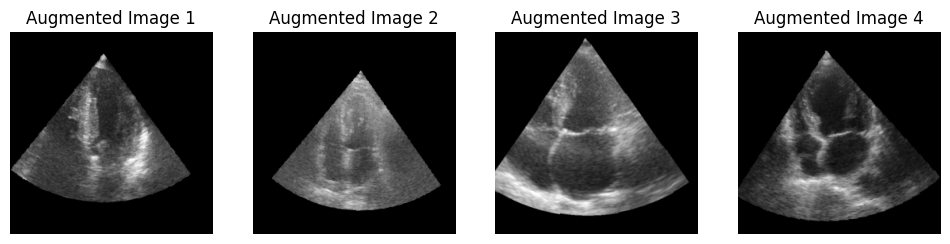

In [11]:
# Create a sample dataset and loader
sample_dataset = CAMUSDataset(train_images_path, train_masks_path, transform=train_transform)
sample_loader = DataLoader(sample_dataset, batch_size=4, shuffle=True)  # Adjust batch_size as needed

# Get a batch of augmented images and masks
images, masks, filenames = next(iter(sample_loader))

# Display the augmented images
fig, axs = plt.subplots(1, 4, figsize=(12, 3))  # Adjust figure size as needed

for i in range(4):  # Assuming batch_size of 4
    # Denormalize the image
    image = images[i].cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5
    axs[i].imshow(image)
    axs[i].set_title(f"Augmented Image {i + 1}")
    axs[i].axis("off")

plt.show()

# Model Initialization  

In [12]:

print(backbones_unet.__available_models__)

['convnext_atto', 'convnext_atto_ols', 'convnext_base', 'convnext_base_384_in22ft1k', 'convnext_base_in22ft1k', 'convnext_base_in22k', 'convnext_femto', 'convnext_femto_ols', 'convnext_large', 'convnext_large_384_in22ft1k', 'convnext_large_in22ft1k', 'convnext_large_in22k', 'convnext_nano', 'convnext_nano_ols', 'convnext_pico', 'convnext_pico_ols', 'convnext_small', 'convnext_small_384_in22ft1k', 'convnext_small_in22ft1k', 'convnext_small_in22k', 'convnext_tiny', 'convnext_tiny_384_in22ft1k', 'convnext_tiny_hnf', 'convnext_tiny_in22ft1k', 'convnext_tiny_in22k', 'convnext_xlarge_384_in22ft1k', 'convnext_xlarge_in22ft1k', 'convnext_xlarge_in22k', 'cs3darknet_focus_l', 'cs3darknet_focus_m', 'cs3darknet_l', 'cs3darknet_m', 'cs3darknet_x', 'cs3edgenet_x', 'cs3se_edgenet_x', 'cs3sedarknet_l', 'cs3sedarknet_x', 'cspdarknet53', 'cspresnet50', 'cspresnext50', 'darknet53', 'darknetaa53', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'densenetblur121d', 'dm_nfnet_f0', 'dm_nfnet_f1',

In [13]:
########################################
# Model Initialization                 #
########################################
# model = smp.Unet(
#     encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#     in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#     classes=NUM_CLASSES,                      # model output channels (number of classes in your dataset)
# )

model = Unet(
    backbone='convnext_base',
    in_channels=3,
    num_classes=NUM_CLASSES
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


#Multi-Class Dice Loss and IoU Calculation

In [14]:
# Custom MultiClassDiceLoss
class MultiClassDiceLoss(nn.Module):
    def __init__(self, from_logits=True, eps=1e-6):
        """
        Initialize the MultiClassDiceLoss.

        Args:
            from_logits (bool): If True, applies softmax to predictions first
            Logits are the raw output values from the final layer of a neural network before any activation function (like softmax) is applied. They're essentially the unnormalized predictions.
            eps (float): Small constant to avoid division by zero
        """
        super().__init__()  # Initialize parent class (nn.Module)
        self.from_logits = from_logits  # Whether input is raw logits
        self.eps = eps  # Small epsilon to prevent division by zero

    def forward(self, y_pred, y_true):
        """
        Compute the multi-class Dice loss.

        Args:
            y_pred: Model predictions (B, C, H, W)
            Variables:
              B: Batch size - The number of samples in the batch.
              C: Number of channels - In semantic segmentation, this usually corresponds to the number of classes.
              H: Height of the feature maps/images.
              W: Width of the feature maps/images.
            y_true: Ground truth labels (B, H, W) with class indices
        """
        # If predictions are logits, convert to probabilities
        if self.from_logits:
            y_pred = torch.softmax(y_pred, dim=1)  # Apply softmax along channel dimension

        B, C, H, W = y_pred.shape  # Get dimensions of prediction tensor
        dice_loss = 0.0  # Initialize total loss

        # Iterate over each class
        for c in range(C):
            # Convert ground truth to one-hot for current class
            y_true_c = (y_true == c).float()  # Binary mask for class c

            # Get predictions for current class
            y_pred_c = y_pred[:, c, :, :]  # Probability map for class c

            # Calculate intersection (TP)
            intersection = (y_pred_c * y_true_c).sum(dim=(1,2))

            # Calculate union (total area)
            union = y_pred_c.sum(dim=(1,2)) + y_true_c.sum(dim=(1,2))

            # Calculate Dice coefficient for current class
            dice_c = (2.0 * intersection + self.eps) / (union + self.eps)

            # Add (1 - dice) to total loss
            dice_loss += (1 - dice_c.mean())

        # Return average loss across all classes
        return dice_loss / C

# Example usage and parameter descriptions:

# For MultiClassDiceLoss:
criterion = MultiClassDiceLoss(
    from_logits=True,  # Set True if model outputs raw logits
    eps=1e-6  # Small constant for numerical stability
)

In [15]:
# Manual IoU Implementation
def compute_iou_manual(pred, target, num_classes=NUM_CLASSES):
    """
    Manually compute IoU (Intersection over Union) for semantic segmentation.

    Args:
        pred (torch.Tensor): Predicted segmentation mask
        target (torch.Tensor): Ground truth segmentation mask
        num_classes (int): Number of classes in the segmentation task

    Returns:
        float: Mean IoU across all classes
    """
    ious = []  # Store IoU for each class
    for c in range(num_classes):
        # Create binary masks for current class
        pred_c = (pred == c)  # Prediction mask for class c
        target_c = (target == c)  # Ground truth mask for class c

        # Calculate intersection and union
        intersection = (pred_c & target_c).sum().item()  # Logical AND for intersection
        union = (pred_c | target_c).sum().item()  # Logical OR for union

        # Calculate IoU if union is non-zero
        if union > 0:
            ious.append(intersection / (union + 1e-6))  # Add small epsilon to prevent division by zero

    # Handle edge case where no valid classes are found
    if len(ious) == 0:
        return 1.0

    # Return mean IoU across all valid classes
    return sum(ious) / len(ious)






#  Training and Validation Workflow for Semantic Segmentation

In [16]:

########################################
# Training & Validation Functions      #
########################################


def train(model, loader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0.0
    epoch_iou = 0.0
    scaler = GradScaler()

    with tqdm(total=len(loader), desc='Training') as pbar:
        for images, masks, _ in loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            with torch.amp.autocast(device_type='cuda'):
                outputs = model(images)
                loss = criterion(outputs, masks)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            preds = torch.argmax(outputs, dim=1)
            batch_iou = compute_iou_manual(preds, masks, num_classes=NUM_CLASSES)

            epoch_loss += loss.item()
            epoch_iou += batch_iou
            pbar.update(1)

    return epoch_loss / len(loader), epoch_iou / len(loader)

In [17]:
def validate(model, loader, criterion, device):
    model.eval()
    val_loss = 0.0
    val_iou = 0.0
    with torch.no_grad():
        with tqdm(total=len(loader), desc='Validation') as pbar:
            for images, masks, _ in loader:
                images, masks = images.to(device), masks.to(device)
                with torch.amp.autocast(device_type='cuda'):
                    outputs = model(images)
                    loss = criterion(outputs, masks)
                preds = torch.argmax(outputs, dim=1)
                batch_iou = compute_iou_manual(preds, masks, num_classes=NUM_CLASSES)
                val_loss += loss.item()
                val_iou += batch_iou
                pbar.update(1)

    return val_loss / len(loader), val_iou / len(loader)



---

# Training Loop




Epoch 1/100


Validation: 100%|██████████| 2/2 [00:06<00:00,  3.20s/it]


Train Loss: 0.7657, Train Dice: 0.2885
Val Loss: 0.7681, Val Dice: 0.2965
Model saved!


<ipython-input-18-1199a72ecd95>:131: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(model_path, "best_model.pth")))


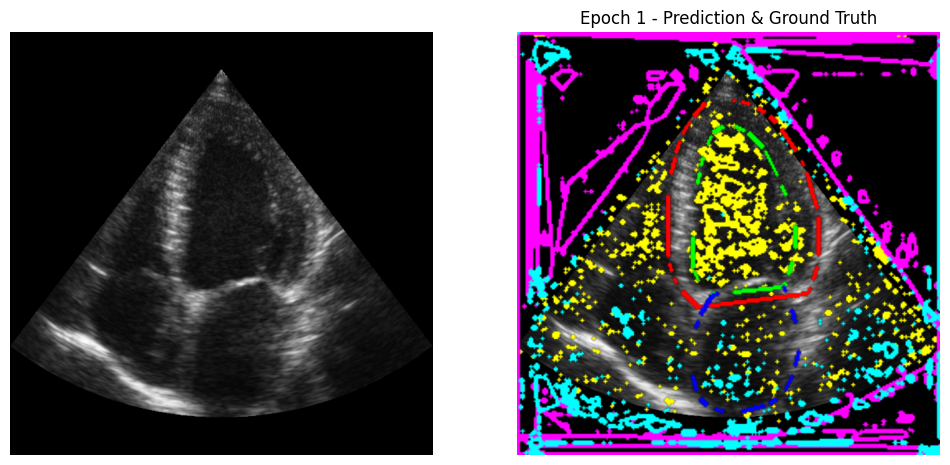

Epoch 2/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


Train Loss: 0.6686, Train Dice: 0.4935
Val Loss: 0.6671, Val Dice: 0.6086
Model saved!


<Figure size 640x480 with 0 Axes>

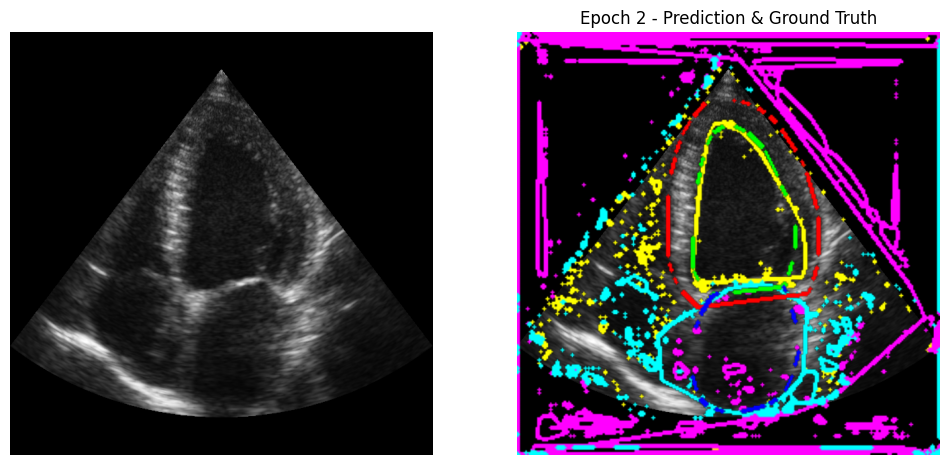

Epoch 3/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


Train Loss: 0.5751, Train Dice: 0.6751
Val Loss: 0.5185, Val Dice: 0.7105
Model saved!


<Figure size 640x480 with 0 Axes>

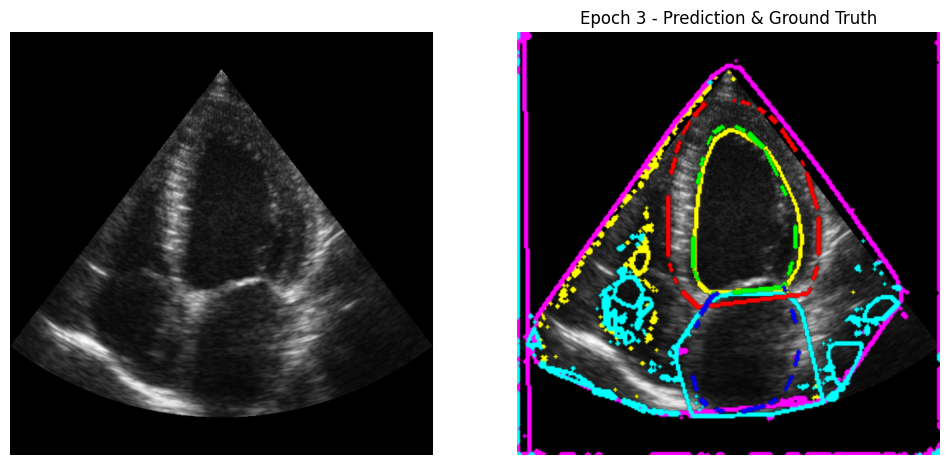

Epoch 4/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


Train Loss: 0.5190, Train Dice: 0.7281
Val Loss: 0.4850, Val Dice: 0.7374
Model saved!


<Figure size 640x480 with 0 Axes>

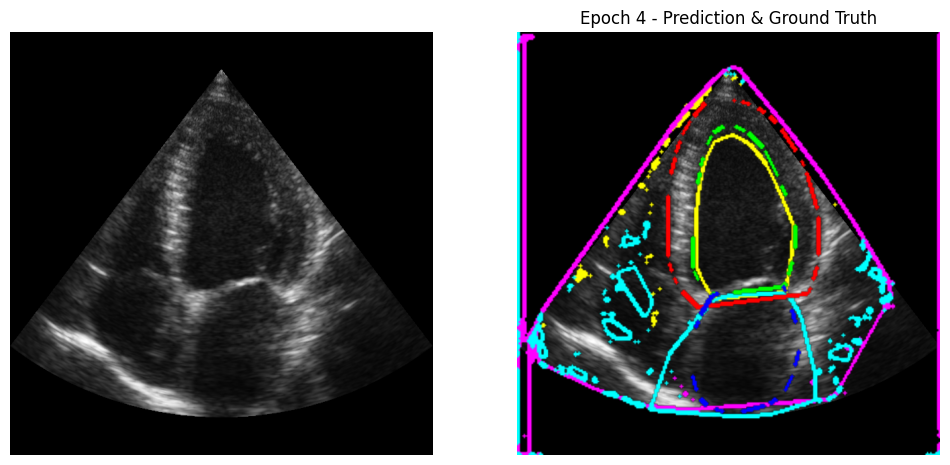

Epoch 5/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


Train Loss: 0.4889, Train Dice: 0.7591
Val Loss: 0.4688, Val Dice: 0.7661
Model saved!


<Figure size 640x480 with 0 Axes>

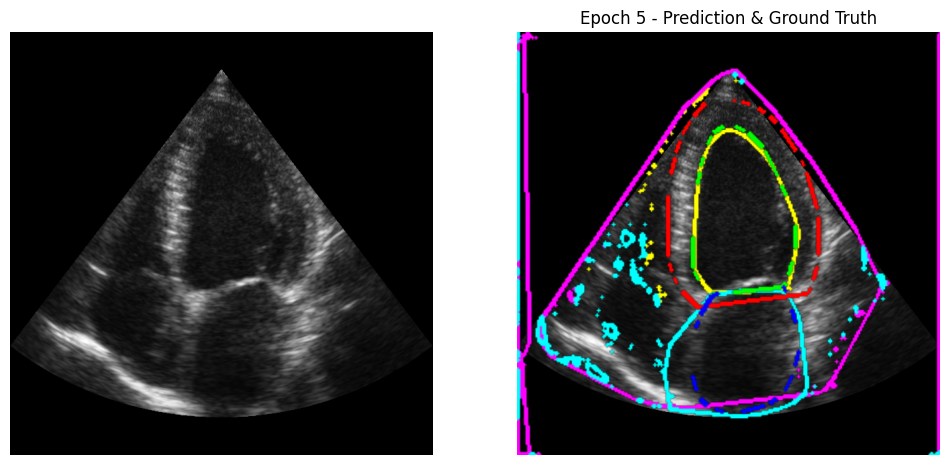

Epoch 6/100


Validation: 100%|██████████| 2/2 [00:03<00:00,  1.53s/it]


Train Loss: 0.4658, Train Dice: 0.7774
Val Loss: 0.4495, Val Dice: 0.7789
Model saved!


<Figure size 640x480 with 0 Axes>

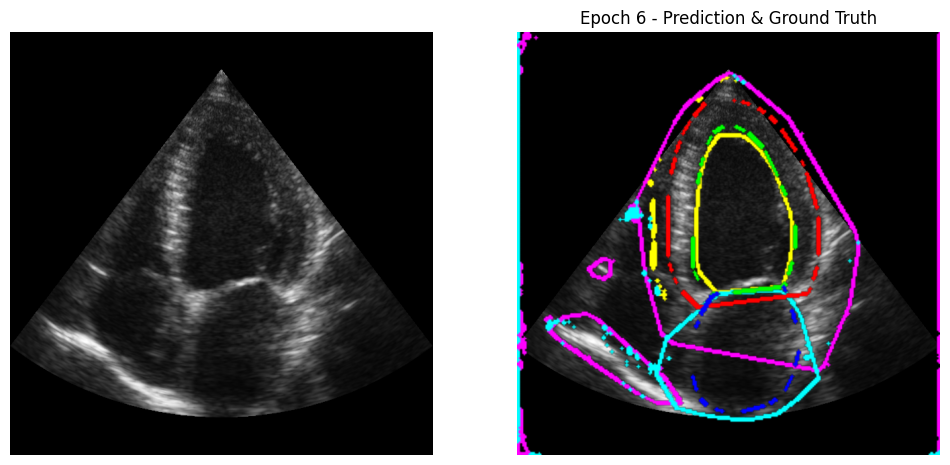

Epoch 7/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.41s/it]


Train Loss: 0.4487, Train Dice: 0.8027
Val Loss: 0.4311, Val Dice: 0.8123
Model saved!


<Figure size 640x480 with 0 Axes>

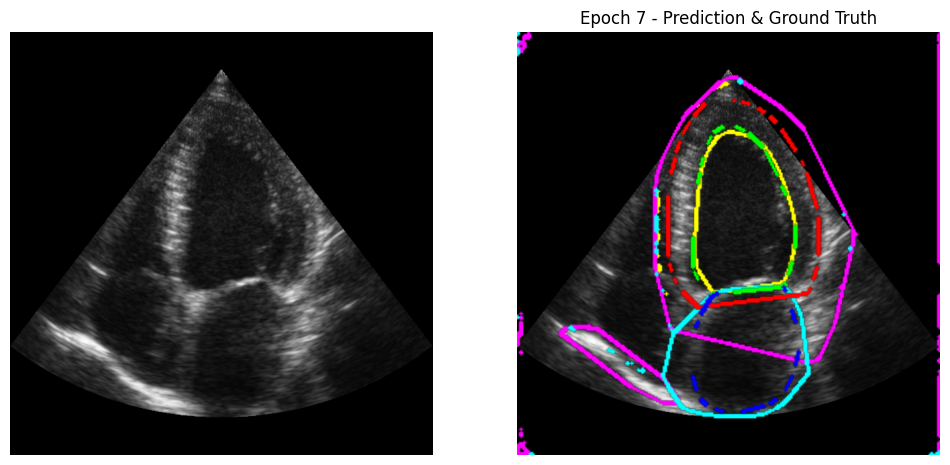

Epoch 8/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


Train Loss: 0.4355, Train Dice: 0.8205
Val Loss: 0.4226, Val Dice: 0.8254
Model saved!


<Figure size 640x480 with 0 Axes>

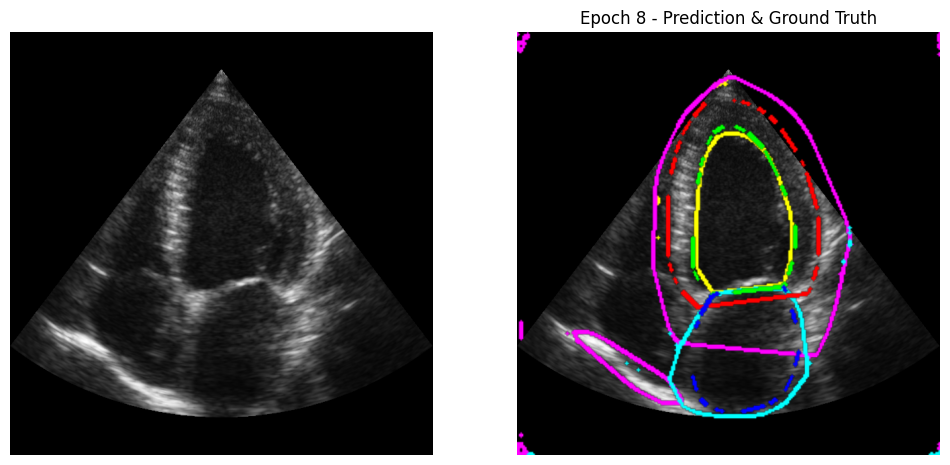

Epoch 9/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


Train Loss: 0.4243, Train Dice: 0.8338
Val Loss: 0.4104, Val Dice: 0.8400
Model saved!


<Figure size 640x480 with 0 Axes>

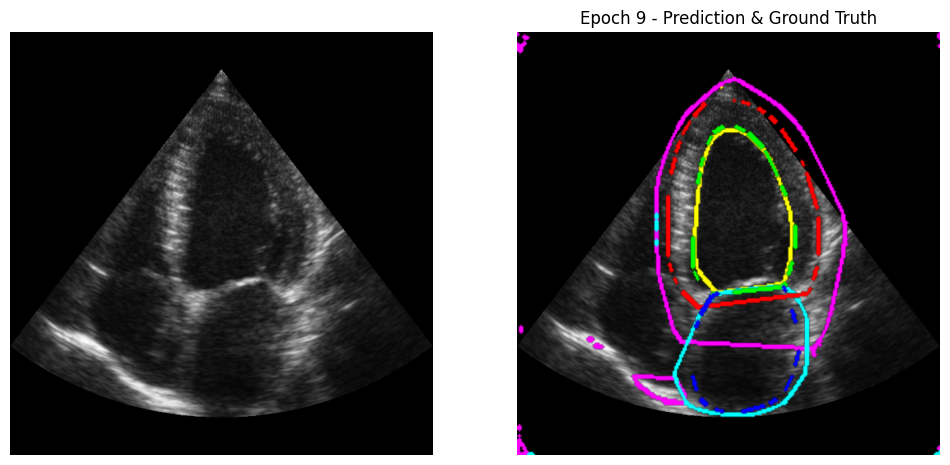

Epoch 10/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


Train Loss: 0.4159, Train Dice: 0.8482
Val Loss: 0.3996, Val Dice: 0.8541
Model saved!


<Figure size 640x480 with 0 Axes>

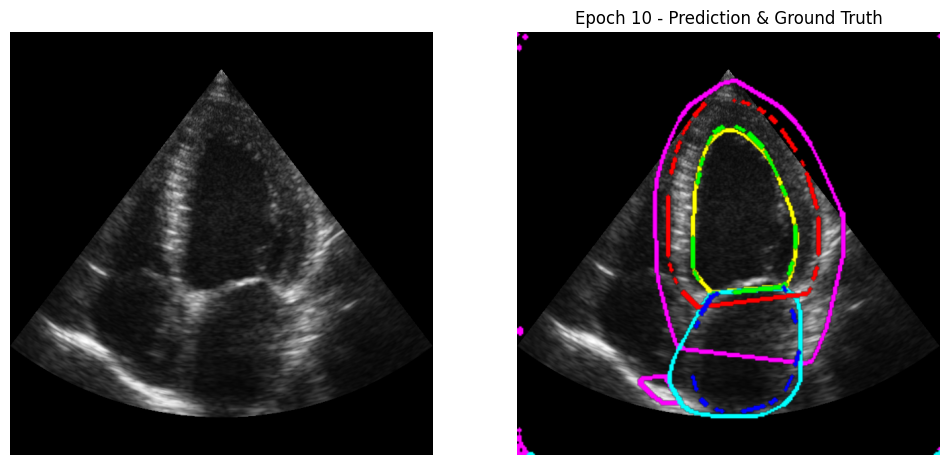

Epoch 11/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]


Train Loss: 0.4063, Train Dice: 0.8604
Val Loss: 0.3969, Val Dice: 0.8626
Model saved!


<Figure size 640x480 with 0 Axes>

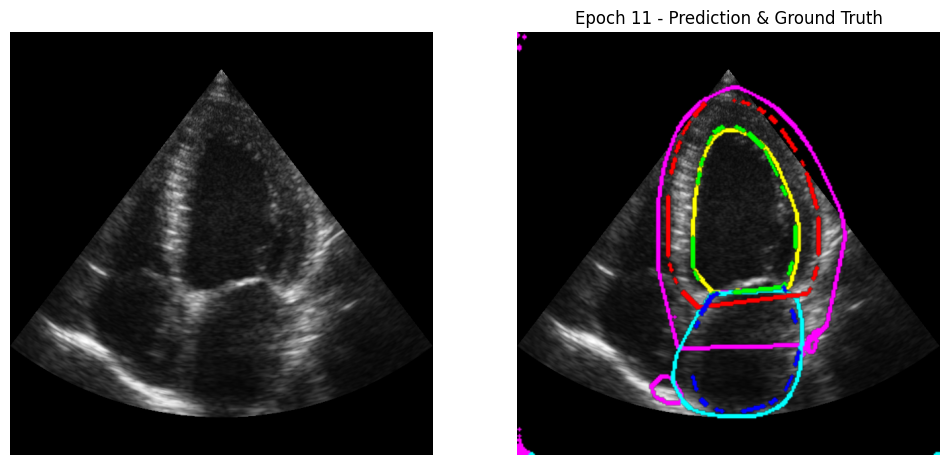

Epoch 12/100


Validation: 100%|██████████| 2/2 [00:03<00:00,  1.55s/it]


Train Loss: 0.3996, Train Dice: 0.8715
Val Loss: 0.3930, Val Dice: 0.8739
Model saved!


<Figure size 640x480 with 0 Axes>

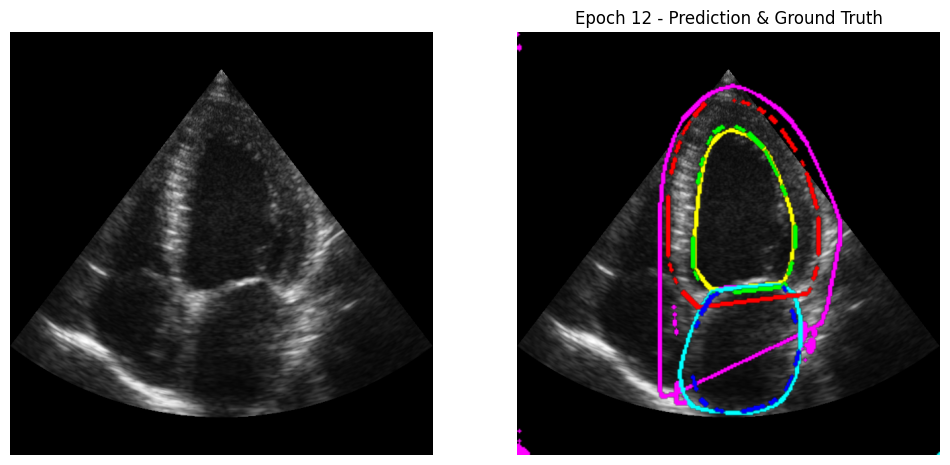

Epoch 13/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


Train Loss: 0.3995, Train Dice: 0.8756
Val Loss: 0.3883, Val Dice: 0.8842
Model saved!


<Figure size 640x480 with 0 Axes>

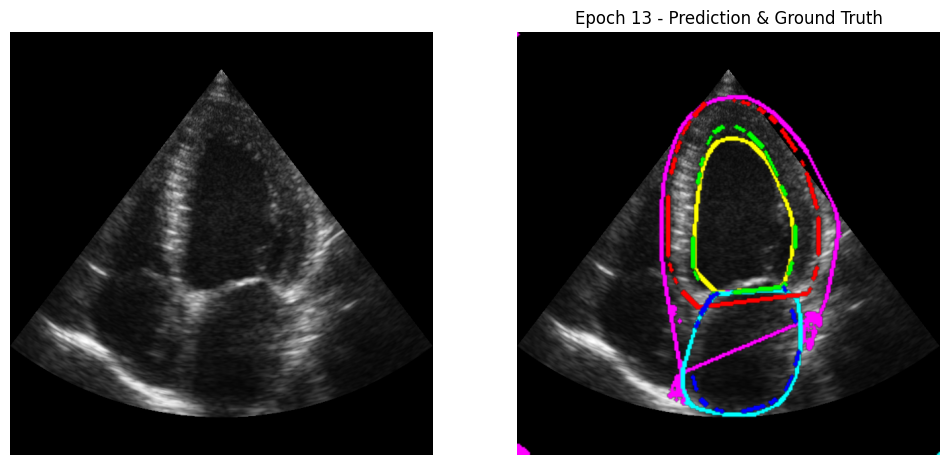

Epoch 14/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


Train Loss: 0.3894, Train Dice: 0.8849
Val Loss: 0.3814, Val Dice: 0.8811
Model saved!


<Figure size 640x480 with 0 Axes>

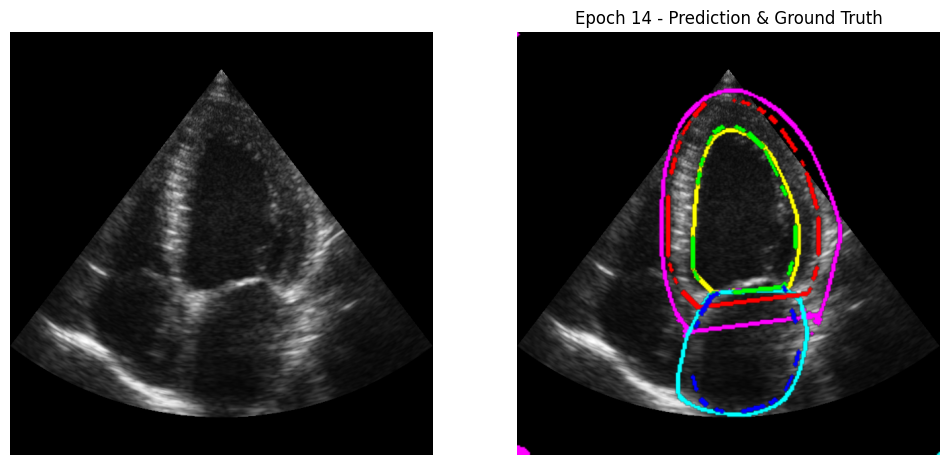

Epoch 15/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


Train Loss: 0.3831, Train Dice: 0.8924
Val Loss: 0.3901, Val Dice: 0.8725
Epoch 16/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


Train Loss: 0.3806, Train Dice: 0.8943
Val Loss: 0.3815, Val Dice: 0.8925
Epoch 17/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


Train Loss: 0.3770, Train Dice: 0.9004
Val Loss: 0.3875, Val Dice: 0.8941
Epoch 18/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


Train Loss: 0.3698, Train Dice: 0.9046
Val Loss: 0.3547, Val Dice: 0.9006
Model saved!


<Figure size 640x480 with 0 Axes>

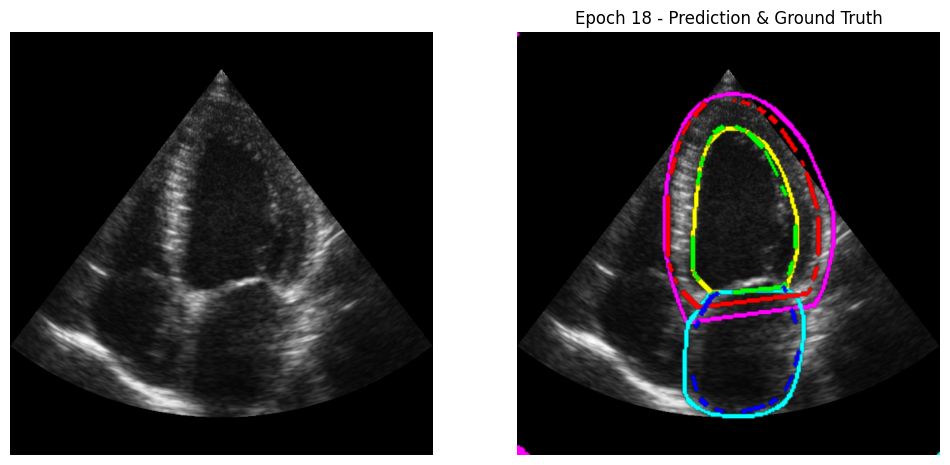

Epoch 19/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


Train Loss: 0.3619, Train Dice: 0.9105
Val Loss: 0.3373, Val Dice: 0.8977
Model saved!


<Figure size 640x480 with 0 Axes>

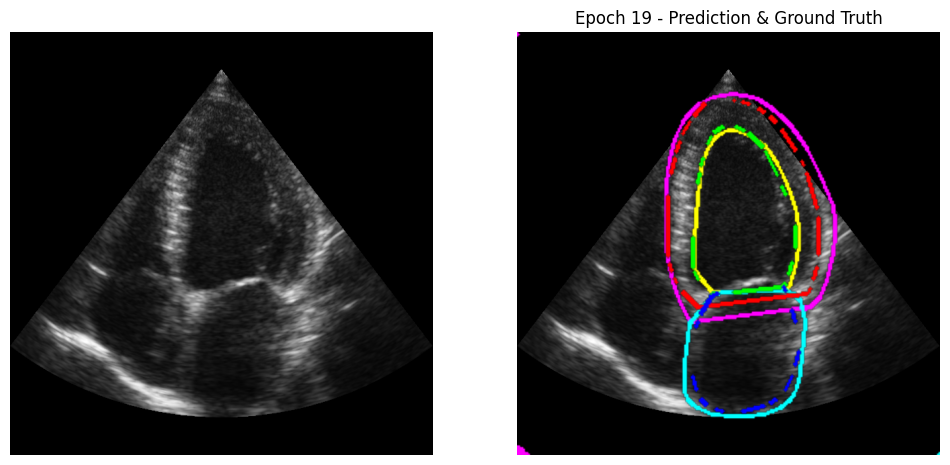

Epoch 20/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.36s/it]


Train Loss: 0.3684, Train Dice: 0.9075
Val Loss: 0.3867, Val Dice: 0.8900
Epoch 21/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


Train Loss: 0.3565, Train Dice: 0.9117
Val Loss: 0.3131, Val Dice: 0.9060
Model saved!


<Figure size 640x480 with 0 Axes>

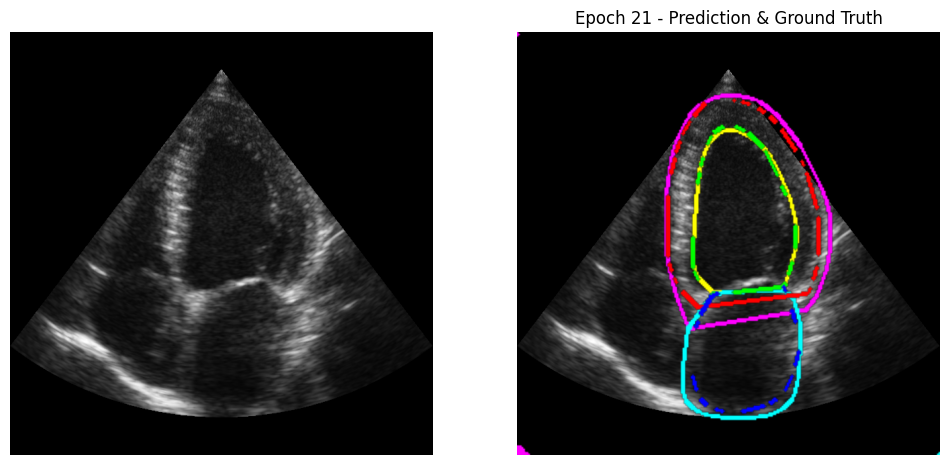

Epoch 22/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


Train Loss: 0.3550, Train Dice: 0.9156
Val Loss: 0.3312, Val Dice: 0.9067
Epoch 23/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


Train Loss: 0.3489, Train Dice: 0.9165
Val Loss: 0.3464, Val Dice: 0.9029
Epoch 24/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


Train Loss: 0.3462, Train Dice: 0.9190
Val Loss: 0.3267, Val Dice: 0.9066
Epoch 25/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


Train Loss: 0.3376, Train Dice: 0.9201
Val Loss: 0.2907, Val Dice: 0.9130
Model saved!


<Figure size 640x480 with 0 Axes>

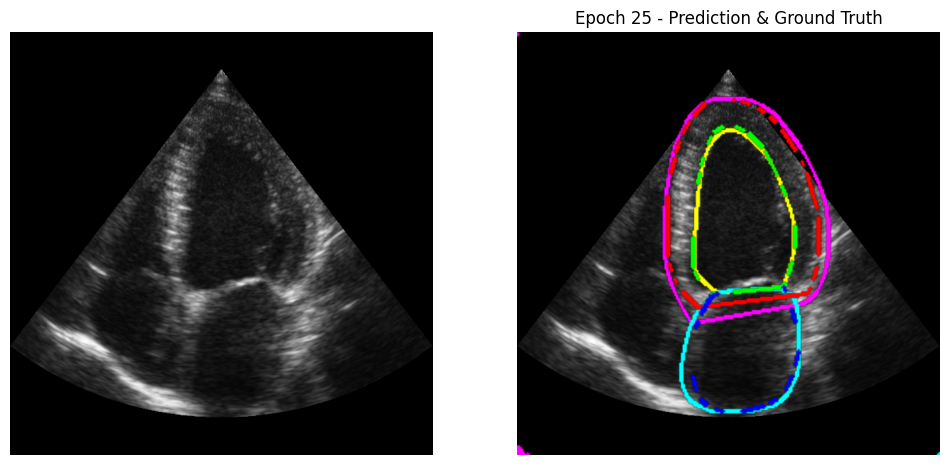

Epoch 26/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


Train Loss: 0.3413, Train Dice: 0.9171
Val Loss: 0.3209, Val Dice: 0.9135
Epoch 27/100


Validation: 100%|██████████| 2/2 [00:03<00:00,  1.52s/it]


Train Loss: 0.3292, Train Dice: 0.9271
Val Loss: 0.3294, Val Dice: 0.9109
Epoch 28/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


Train Loss: 0.3294, Train Dice: 0.9265
Val Loss: 0.3196, Val Dice: 0.9120
Epoch 29/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


Train Loss: 0.3248, Train Dice: 0.9292
Val Loss: 0.3203, Val Dice: 0.9132
Epoch 30/100


Validation: 100%|██████████| 2/2 [00:03<00:00,  1.52s/it]


Train Loss: 0.3180, Train Dice: 0.9324
Val Loss: 0.3098, Val Dice: 0.9087
Epoch 31/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


Train Loss: 0.3173, Train Dice: 0.9302
Val Loss: 0.3457, Val Dice: 0.9095
Epoch 32/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


Train Loss: 0.3095, Train Dice: 0.9324
Val Loss: 0.3461, Val Dice: 0.9102
Epoch 33/100


Validation: 100%|██████████| 2/2 [00:03<00:00,  1.52s/it]


Train Loss: 0.3082, Train Dice: 0.9334
Val Loss: 0.2807, Val Dice: 0.9134
Model saved!


<Figure size 640x480 with 0 Axes>

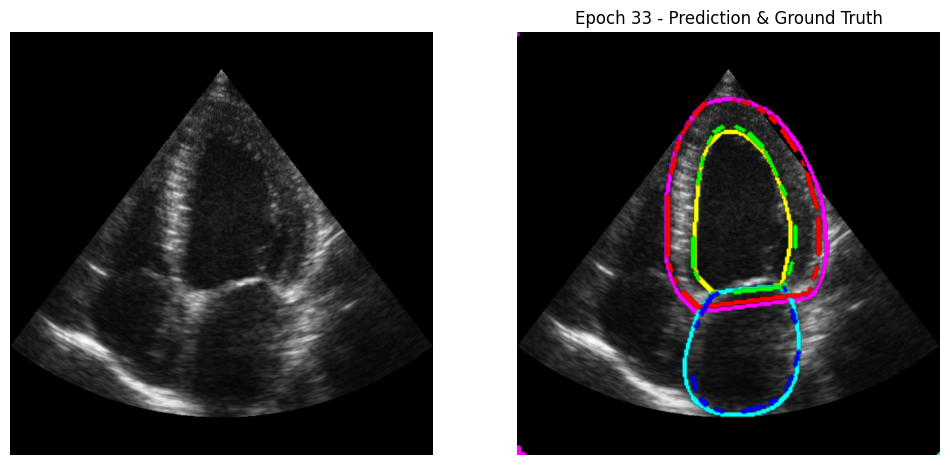

Epoch 34/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it]


Train Loss: 0.3081, Train Dice: 0.9341
Val Loss: 0.3552, Val Dice: 0.9117
Epoch 35/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


Train Loss: 0.3077, Train Dice: 0.9328
Val Loss: 0.3691, Val Dice: 0.9145
Epoch 36/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


Train Loss: 0.2978, Train Dice: 0.9386
Val Loss: 0.2413, Val Dice: 0.9240
Model saved!


<Figure size 640x480 with 0 Axes>

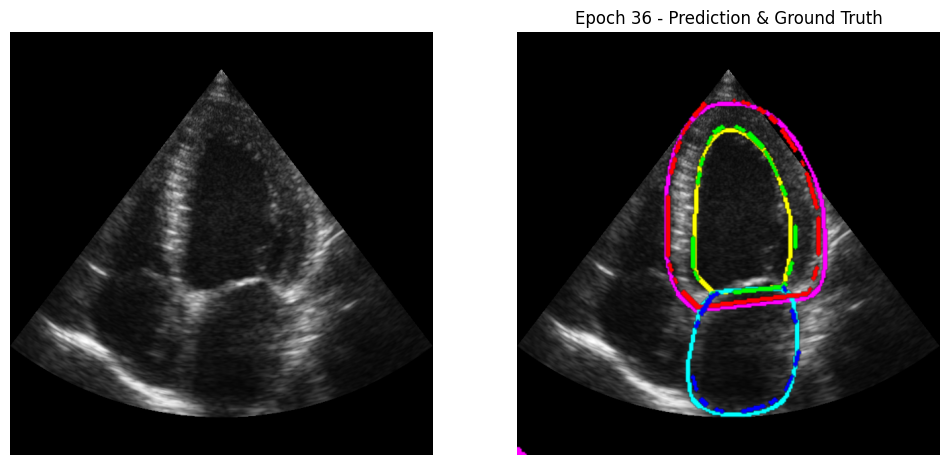

Epoch 37/100


Validation: 100%|██████████| 2/2 [00:03<00:00,  1.57s/it]


Train Loss: 0.3040, Train Dice: 0.9327
Val Loss: 0.3059, Val Dice: 0.9153
Epoch 38/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


Train Loss: 0.2964, Train Dice: 0.9383
Val Loss: 0.3420, Val Dice: 0.9156
Epoch 39/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Train Loss: 0.2930, Train Dice: 0.9412
Val Loss: 0.3180, Val Dice: 0.9148
Epoch 40/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.45s/it]


Train Loss: 0.2893, Train Dice: 0.9427
Val Loss: 0.2899, Val Dice: 0.9134
Epoch 41/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


Train Loss: 0.2892, Train Dice: 0.9418
Val Loss: 0.2472, Val Dice: 0.9210
Epoch 42/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


Train Loss: 0.2863, Train Dice: 0.9431
Val Loss: 0.2847, Val Dice: 0.9207
Epoch 43/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.42s/it]


Train Loss: 0.2810, Train Dice: 0.9453
Val Loss: 0.2674, Val Dice: 0.9197
Epoch 44/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


Train Loss: 0.2773, Train Dice: 0.9448
Val Loss: 0.3451, Val Dice: 0.9142
Epoch 45/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


Train Loss: 0.2745, Train Dice: 0.9464
Val Loss: 0.2959, Val Dice: 0.9186
Epoch 46/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.44s/it]


Train Loss: 0.2743, Train Dice: 0.9472
Val Loss: 0.3253, Val Dice: 0.9151
Epoch 47/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


Train Loss: 0.2734, Train Dice: 0.9477
Val Loss: 0.3009, Val Dice: 0.9222
Epoch 48/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


Train Loss: 0.2682, Train Dice: 0.9500
Val Loss: 0.2780, Val Dice: 0.9223
Epoch 49/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.39s/it]


Train Loss: 0.2656, Train Dice: 0.9492
Val Loss: 0.2794, Val Dice: 0.9178
Epoch 50/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


Train Loss: 0.2657, Train Dice: 0.9504
Val Loss: 0.2436, Val Dice: 0.9218
Epoch 51/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


Train Loss: 0.2563, Train Dice: 0.9524
Val Loss: 0.2930, Val Dice: 0.9203
Epoch 52/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.39s/it]


Train Loss: 0.2610, Train Dice: 0.9501
Val Loss: 0.2401, Val Dice: 0.9257
Model saved!


<Figure size 640x480 with 0 Axes>

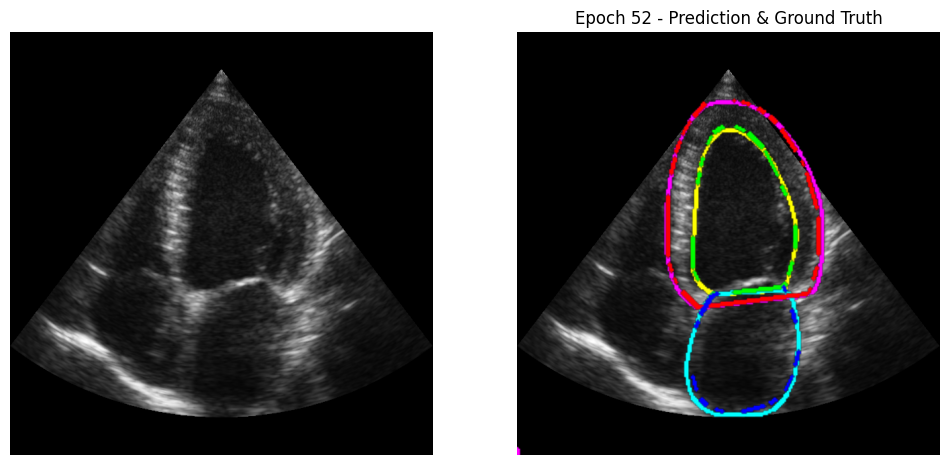

Epoch 53/100


Validation: 100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


Train Loss: 0.2549, Train Dice: 0.9526
Val Loss: 0.2828, Val Dice: 0.9174
Epoch 54/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


Train Loss: 0.2534, Train Dice: 0.9512
Val Loss: 0.2450, Val Dice: 0.9240
Epoch 55/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


Train Loss: 0.2483, Train Dice: 0.9537
Val Loss: 0.2244, Val Dice: 0.9250
Model saved!


<Figure size 640x480 with 0 Axes>

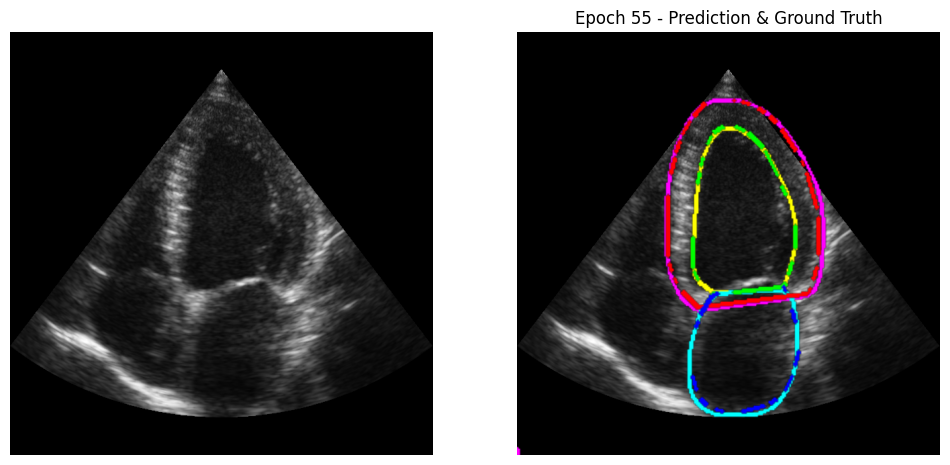

Epoch 56/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it]


Train Loss: 0.2505, Train Dice: 0.9490
Val Loss: 0.2467, Val Dice: 0.9249
Epoch 57/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


Train Loss: 0.2458, Train Dice: 0.9519
Val Loss: 0.2200, Val Dice: 0.9244
Model saved!


<Figure size 640x480 with 0 Axes>

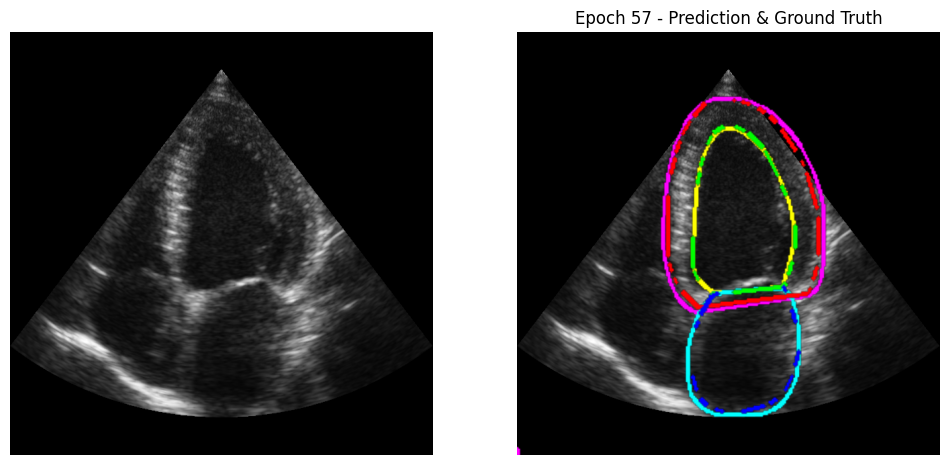

Epoch 58/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


Train Loss: 0.2457, Train Dice: 0.9486
Val Loss: 0.3279, Val Dice: 0.9152
Epoch 59/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


Train Loss: 0.2421, Train Dice: 0.9515
Val Loss: 0.2258, Val Dice: 0.9252
Epoch 60/100


Validation: 100%|██████████| 2/2 [00:03<00:00,  1.57s/it]


Train Loss: 0.2379, Train Dice: 0.9549
Val Loss: 0.2498, Val Dice: 0.9239
Epoch 61/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


Train Loss: 0.2354, Train Dice: 0.9552
Val Loss: 0.2333, Val Dice: 0.9216
Epoch 62/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


Train Loss: 0.2327, Train Dice: 0.9553
Val Loss: 0.2339, Val Dice: 0.9228
Epoch 63/100


Validation: 100%|██████████| 2/2 [00:03<00:00,  1.55s/it]


Train Loss: 0.2297, Train Dice: 0.9576
Val Loss: 0.2290, Val Dice: 0.9253
Epoch 64/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


Train Loss: 0.2257, Train Dice: 0.9573
Val Loss: 0.2353, Val Dice: 0.9262
Epoch 65/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


Train Loss: 0.2239, Train Dice: 0.9582
Val Loss: 0.2265, Val Dice: 0.9222
Epoch 66/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.45s/it]


Train Loss: 0.2240, Train Dice: 0.9593
Val Loss: 0.2540, Val Dice: 0.9266
Epoch 67/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


Train Loss: 0.2218, Train Dice: 0.9603
Val Loss: 0.2483, Val Dice: 0.9248
Epoch 68/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


Train Loss: 0.2175, Train Dice: 0.9602
Val Loss: 0.2194, Val Dice: 0.9282
Model saved!


<Figure size 640x480 with 0 Axes>

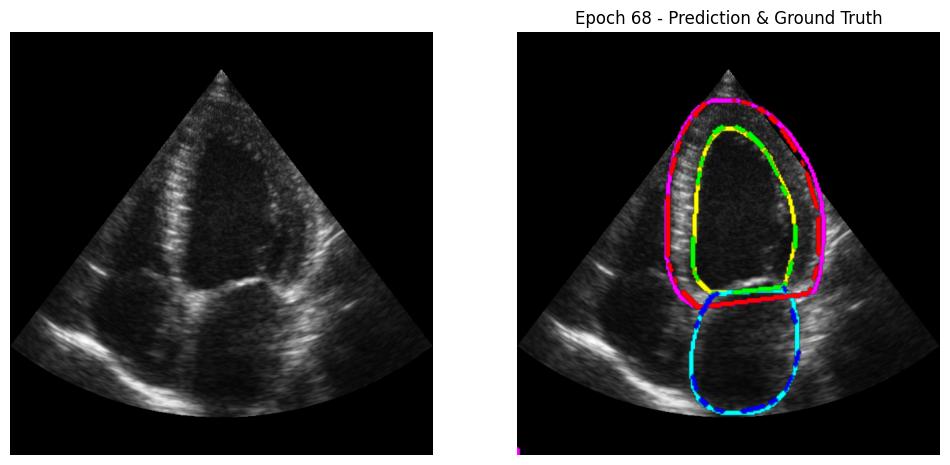

Epoch 69/100


Validation: 100%|██████████| 2/2 [00:03<00:00,  1.54s/it]


Train Loss: 0.2146, Train Dice: 0.9606
Val Loss: 0.2361, Val Dice: 0.9257
Epoch 70/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


Train Loss: 0.2106, Train Dice: 0.9627
Val Loss: 0.2394, Val Dice: 0.9256
Epoch 71/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


Train Loss: 0.2110, Train Dice: 0.9623
Val Loss: 0.2163, Val Dice: 0.9262
Model saved!


<Figure size 640x480 with 0 Axes>

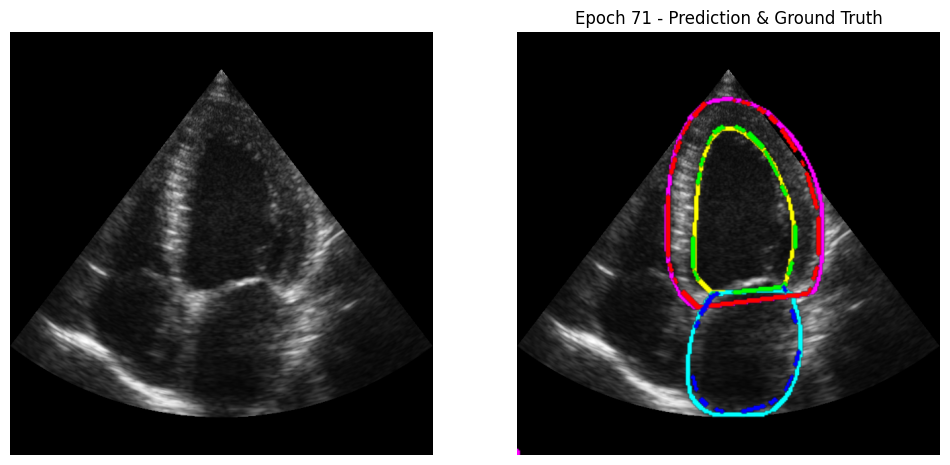

Epoch 72/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


Train Loss: 0.2114, Train Dice: 0.9610
Val Loss: 0.2100, Val Dice: 0.9247
Model saved!


<Figure size 640x480 with 0 Axes>

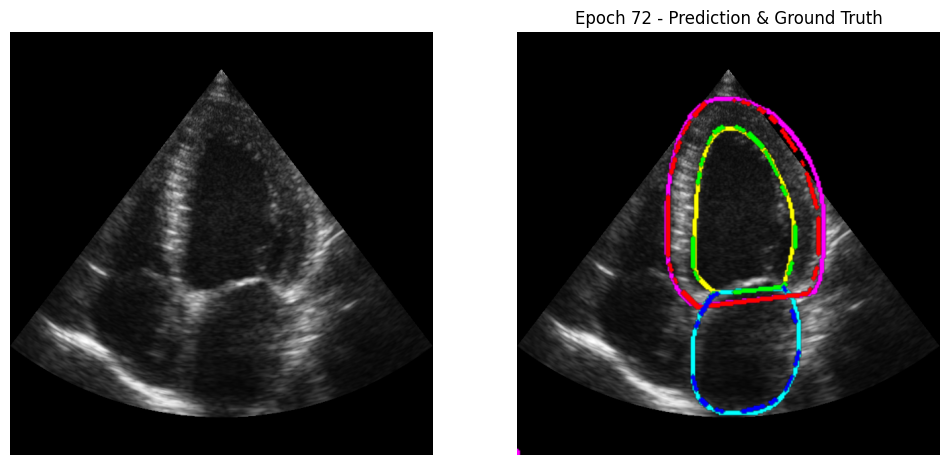

Epoch 73/100


Validation: 100%|██████████| 2/2 [00:03<00:00,  1.62s/it]


Train Loss: 0.2092, Train Dice: 0.9595
Val Loss: 0.2194, Val Dice: 0.9269
Epoch 74/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Train Loss: 0.2027, Train Dice: 0.9623
Val Loss: 0.2280, Val Dice: 0.9264
Epoch 75/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


Train Loss: 0.2033, Train Dice: 0.9635
Val Loss: 0.2215, Val Dice: 0.9265
Epoch 76/100


Validation: 100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Train Loss: 0.1973, Train Dice: 0.9649
Val Loss: 0.2114, Val Dice: 0.9274
Epoch 77/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


Train Loss: 0.1940, Train Dice: 0.9660
Val Loss: 0.1920, Val Dice: 0.9271
Model saved!


<Figure size 640x480 with 0 Axes>

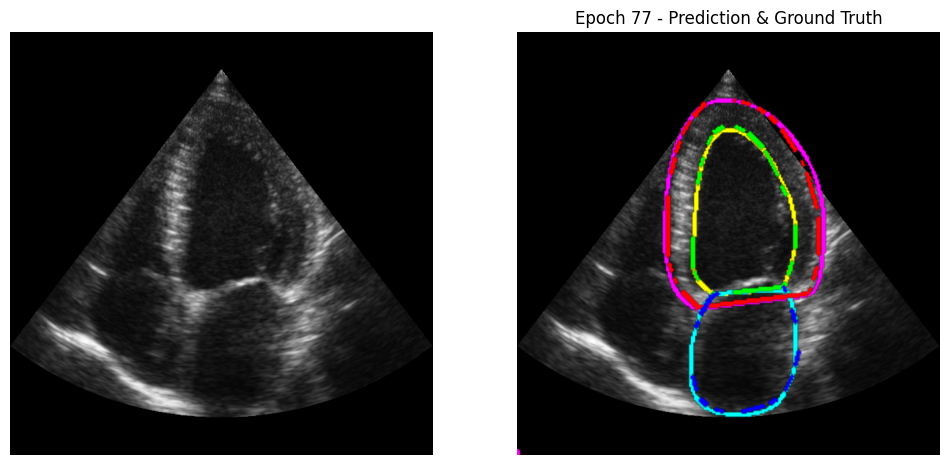

Epoch 78/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


Train Loss: 0.1949, Train Dice: 0.9646
Val Loss: 0.1996, Val Dice: 0.9269
Epoch 79/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.38s/it]


Train Loss: 0.1931, Train Dice: 0.9631
Val Loss: 0.2095, Val Dice: 0.9239
Epoch 80/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


Train Loss: 0.1909, Train Dice: 0.9620
Val Loss: 0.1915, Val Dice: 0.9266
Model saved!


<Figure size 640x480 with 0 Axes>

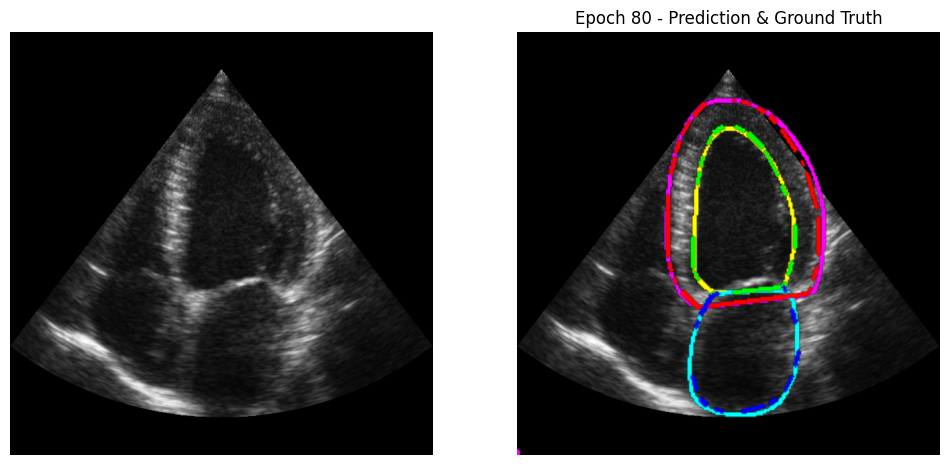

Epoch 81/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


Train Loss: 0.1870, Train Dice: 0.9659
Val Loss: 0.1967, Val Dice: 0.9279
Epoch 82/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


Train Loss: 0.1848, Train Dice: 0.9659
Val Loss: 0.1942, Val Dice: 0.9268
Epoch 83/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.40s/it]


Train Loss: 0.1830, Train Dice: 0.9675
Val Loss: 0.1992, Val Dice: 0.9264
Epoch 84/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


Train Loss: 0.1802, Train Dice: 0.9666
Val Loss: 0.1985, Val Dice: 0.9263
Epoch 85/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


Train Loss: 0.1831, Train Dice: 0.9664
Val Loss: 0.1954, Val Dice: 0.9267
Epoch 86/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.23s/it]


Train Loss: 0.1770, Train Dice: 0.9672
Val Loss: 0.1774, Val Dice: 0.9285
Model saved!


<Figure size 640x480 with 0 Axes>

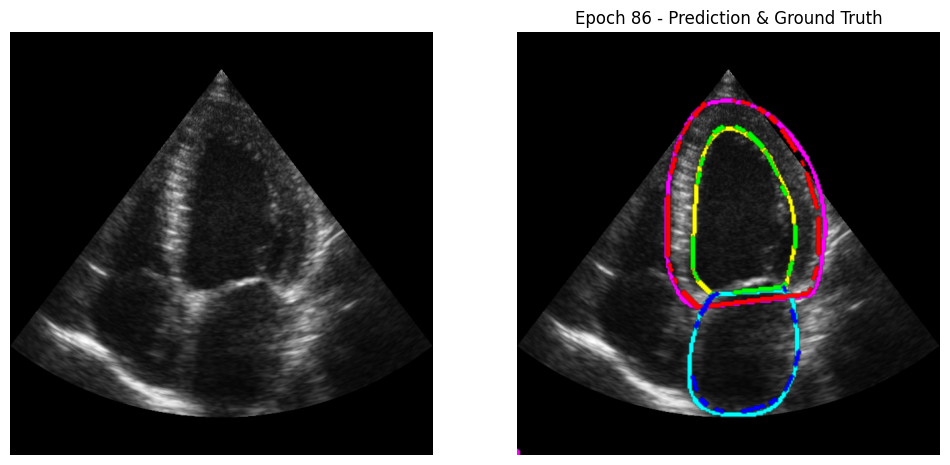

Epoch 87/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Train Loss: 0.1745, Train Dice: 0.9693
Val Loss: 0.1809, Val Dice: 0.9288
Epoch 88/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


Train Loss: 0.1713, Train Dice: 0.9687
Val Loss: 0.1765, Val Dice: 0.9298
Model saved!


<Figure size 640x480 with 0 Axes>

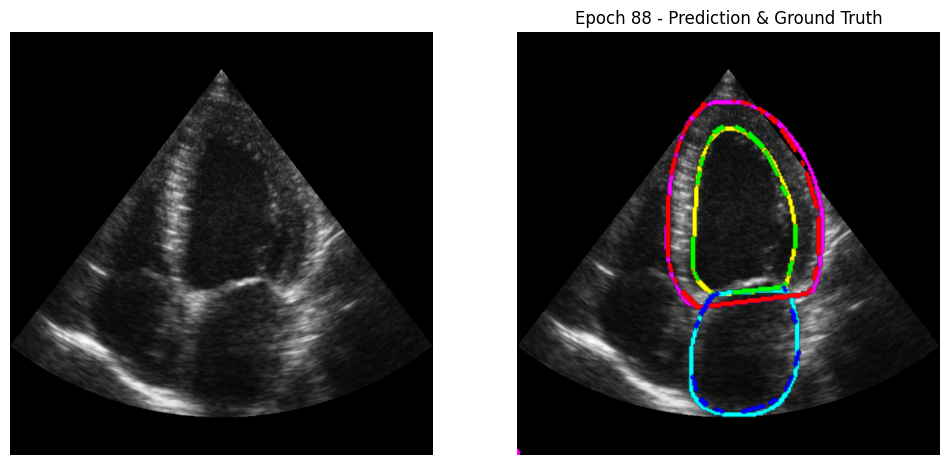

Epoch 89/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


Train Loss: 0.1714, Train Dice: 0.9692
Val Loss: 0.1814, Val Dice: 0.9279
Epoch 90/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


Train Loss: 0.1694, Train Dice: 0.9691
Val Loss: 0.1858, Val Dice: 0.9295
Epoch 91/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


Train Loss: 0.1681, Train Dice: 0.9699
Val Loss: 0.1779, Val Dice: 0.9297
Epoch 92/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


Train Loss: 0.1665, Train Dice: 0.9689
Val Loss: 0.1843, Val Dice: 0.9286
Epoch 93/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.24s/it]


Train Loss: 0.1636, Train Dice: 0.9682
Val Loss: 0.1754, Val Dice: 0.9252
Model saved!


<Figure size 640x480 with 0 Axes>

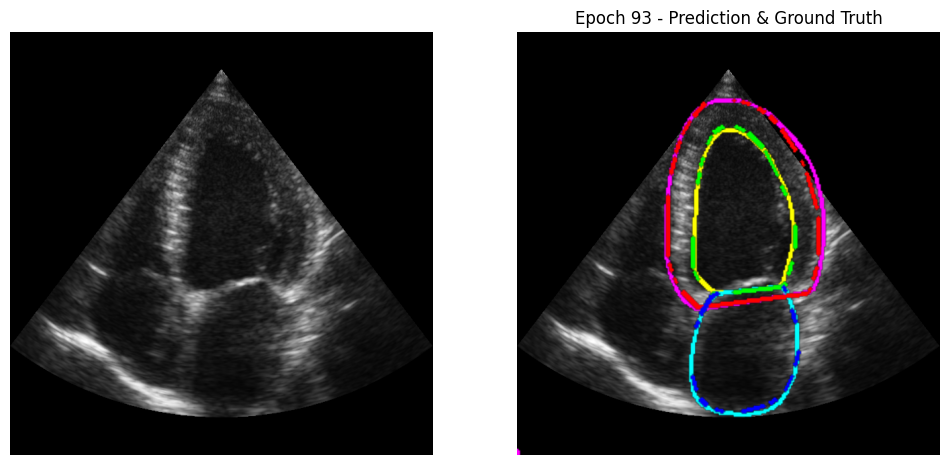

Epoch 94/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


Train Loss: 0.1639, Train Dice: 0.9684
Val Loss: 0.1760, Val Dice: 0.9292
Epoch 95/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


Train Loss: 0.1615, Train Dice: 0.9681
Val Loss: 0.1672, Val Dice: 0.9295
Model saved!


<Figure size 640x480 with 0 Axes>

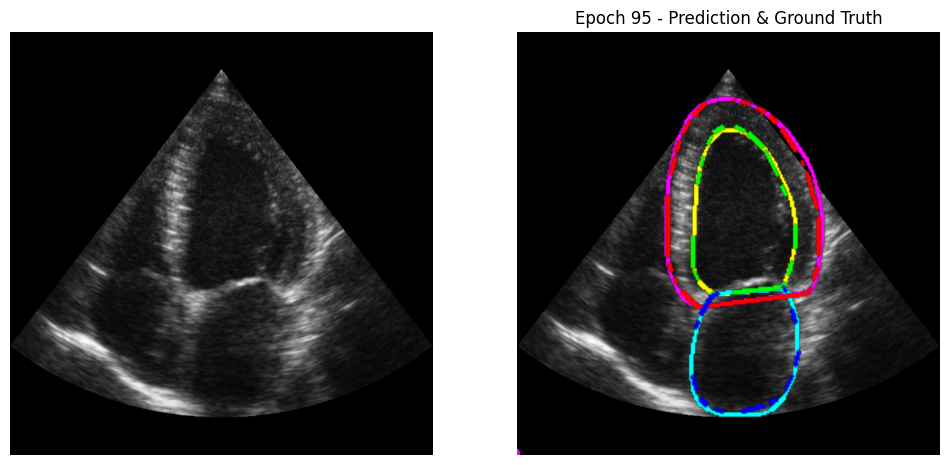

Epoch 96/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]


Train Loss: 0.1553, Train Dice: 0.9695
Val Loss: 0.1776, Val Dice: 0.9285
Epoch 97/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Train Loss: 0.1555, Train Dice: 0.9697
Val Loss: 0.1692, Val Dice: 0.9291
Epoch 98/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


Train Loss: 0.1547, Train Dice: 0.9685
Val Loss: 0.1716, Val Dice: 0.9265
Epoch 99/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.36s/it]


Train Loss: 0.1524, Train Dice: 0.9710
Val Loss: 0.1693, Val Dice: 0.9302
Epoch 100/100


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


Train Loss: 0.1508, Train Dice: 0.9706
Val Loss: 0.1696, Val Dice: 0.9298
Video saved successfully with 32 frames!


<Figure size 640x480 with 0 Axes>

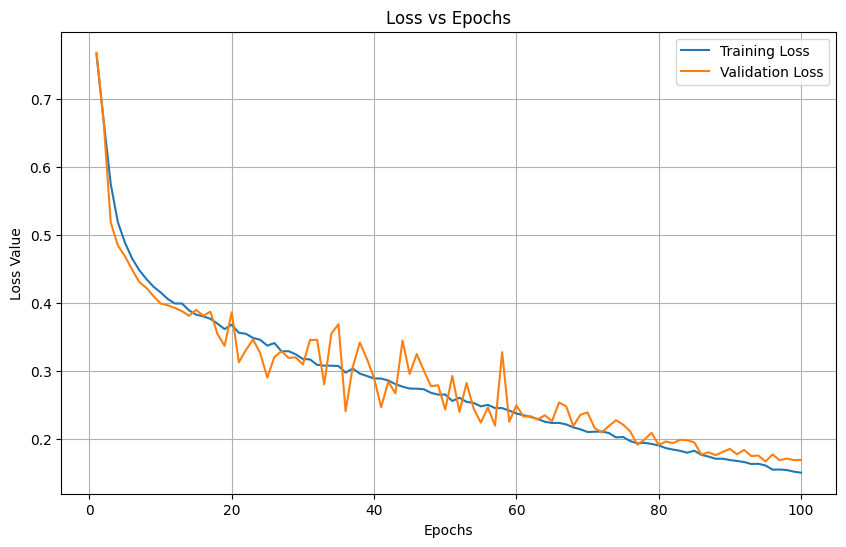

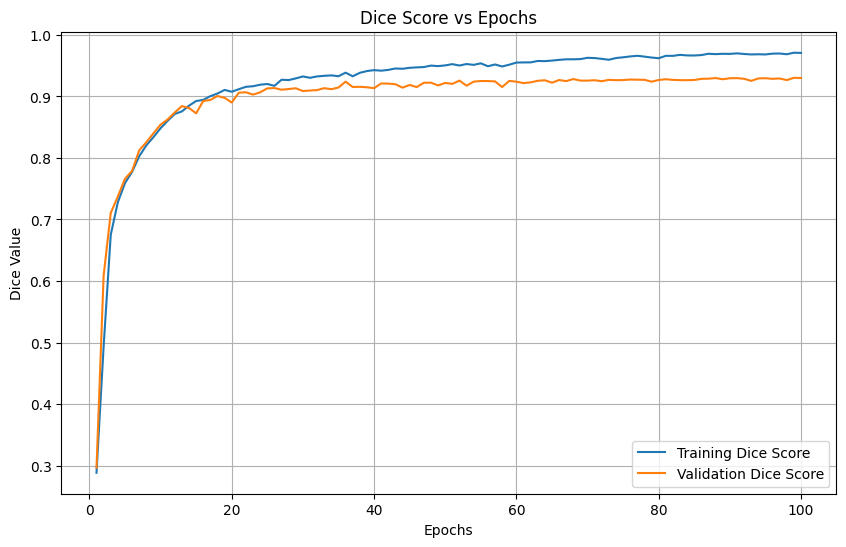

In [18]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import torch

# Lists to store metrics
train_losses = []
val_losses = []
train_dices = []
val_dices = []
best_val_loss = float('inf')
patience = 0
prediction_frames = []

# Color schemes
pred_colors = {1: (0, 255, 255), 2: (255, 0, 255), 3: (255, 255, 0)}  # Yellow, Magenta, Cyan
gt_colors = {1: (0, 255, 0), 2: (0, 0, 255), 3: (255, 0, 0)}  # Green, Blue, Red

def create_solid_contours(mask, class_colors, thickness=2, alpha=1):
    mask_solid = np.zeros((*mask.shape, 4), dtype=np.uint8)
    for c, color in class_colors.items():
        binary_mask = (mask == c).astype(np.uint8)
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        convex_contours = [cv2.convexHull(cnt) for cnt in contours]
        cv2.drawContours(mask_solid, convex_contours, -1, (*color, int(255 * alpha)), thickness=thickness)
    return mask_solid

def create_hashed_overlay(mask, class_colors, thickness=2, dash_length=2, gap_length=7, alpha=1):
    mask_hashed = np.zeros((*mask.shape, 4), dtype=np.uint8)
    for c, color in class_colors.items():
        binary_mask = (mask == c).astype(np.uint8)
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        convex_contours = [cv2.convexHull(cnt) for cnt in contours]
        for cnt in convex_contours:
            perimeter = cv2.arcLength(cnt, True)
            num_points = max(2, int(perimeter / (dash_length + gap_length)))
            resampled_points = [cnt[i][0] for i in np.linspace(0, len(cnt)-1, num_points, dtype=int)]
            for i in range(0, len(resampled_points)-1, 2):
                cv2.line(mask_hashed, tuple(resampled_points[i]), tuple(resampled_points[i+1]), (*color, int(255 * alpha)), thickness)
    return mask_hashed

def plot_metrics(train_metric, val_metric, metric_name, ylabel):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_metric) + 1), train_metric, label=f'Training {metric_name}')
    plt.plot(range(1, len(val_metric) + 1), val_metric, label=f'Validation {metric_name}')
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.title(f'{metric_name} vs Epochs')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{metric_name.lower()}_plot.png')
    plt.show()
    plt.close()

def visualize_prediction_and_show(model, dataset, idx, epoch, device):
    model.eval()
    original_image_path = os.path.join(test_images_path, test_dataset.images[idx])
    original_image = cv2.imread(original_image_path)

    image, mask, _ = dataset[idx]
    with torch.no_grad():
        pred = torch.argmax(model(image.unsqueeze(0).to(device)), dim=1).squeeze(0).cpu().numpy()

    # Create overlays
    pred_solid = create_solid_contours(pred, pred_colors)
    gt_hashed = create_hashed_overlay(mask.cpu().numpy(), gt_colors)

    # Resize to match original image size
    pred_solid = cv2.resize(pred_solid, (original_image.shape[1], original_image.shape[0]))
    gt_hashed = cv2.resize(gt_hashed, (original_image.shape[1], original_image.shape[0]))

    # Convert original image to 4-channel (BGRA)
    result = cv2.cvtColor(original_image, cv2.COLOR_BGR2BGRA)

    # Blend overlays
    for overlay in [pred_solid, gt_hashed]:
        alpha = overlay[:, :, 3:4].astype(float) / 255
        result[:, :, :3] = (overlay[:, :, :3] * alpha + result[:, :, :3] * (1 - alpha)).astype(np.uint8)

    # Display results
    plt.figure(figsize=(12, 6))
    for i, img in enumerate([original_image, result]):
        plt.subplot(1, 2, i+1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
    plt.title(f"Epoch {epoch+1} - Prediction & Ground Truth")
    plt.show(block=False)
    plt.pause(0.1)
    plt.clf()

    # Define text properties
    text = f'Epoch: {epoch+1}'
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    thickness = 2

    # Get text size to create a background
    (text_width, text_height), baseline = cv2.getTextSize(text, font, font_scale, thickness)

    # Define text position
    x, y = 10, 30  # Bottom-left corner of the text

    # Draw white rectangle as background
    cv2.rectangle(result, (x - 5, y - text_height - 5), (x + text_width + 5, y + baseline), (255, 255, 255), -1)

    # Add black text on top of the white background
    cv2.putText(result, text, (x, y), font, font_scale, (0, 0, 0), thickness, cv2.LINE_AA)

    # Convert result to BGR for saving in the video
    prediction_frames.append(cv2.cvtColor(result, cv2.COLOR_BGRA2BGR))

test_image_idx = 21
for epoch in range(NBEPOCHS):
    print(f"Epoch {epoch+1}/{NBEPOCHS}")
    train_loss, train_iou = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_iou = validate(model, valid_loader, criterion, device)

    train_dices.append(2 * train_iou / (1 + train_iou))
    val_dices.append(2 * val_iou / (1 + val_iou))
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Train Loss: {train_loss:.4f}, Train Dice: {train_dices[-1]:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Dice: {val_dices[-1]:.4f}")

    if val_loss < best_val_loss:
        best_val_loss, patience = val_loss, 0
        torch.save(model.state_dict(), os.path.join(model_path, "best_model.pth"))
        print("Model saved!")
        model.load_state_dict(torch.load(os.path.join(model_path, "best_model.pth")))
        visualize_prediction_and_show(model, test_dataset, test_image_idx, epoch, device)
    else:
        patience += 1
        if patience >= NBPATIENCE_EPOCHS:
            print("Early stopping triggered!")
            break

# Save predictions as a video
if prediction_frames:
    height, width = prediction_frames[0].shape[:2]

    # Define the codec and create VideoWriter object
    video_writer = cv2.VideoWriter("predictions_only_video.avi",
                                   cv2.VideoWriter_fourcc(*'XVID'),
                                   2,  # FPS
                                   (width, height))

    for frame in prediction_frames:
        video_writer.write(frame)

    video_writer.release()
    print(f"Video saved successfully with {len(prediction_frames)} frames!")

plot_metrics(train_losses, val_losses, 'Loss', 'Loss Value')
plot_metrics(train_dices, val_dices, 'Dice Score', 'Dice Value')


# Separate datasets for ED and ES frames


In [19]:
# Separate datasets for ED and ES frames
ed_images = []
es_images = []

# Filter test dataset based on image name
for image, mask, filename in test_dataset:
    # print("Image name: ", filename)
    if filename.endswith("ED.png"):
        # print("Image name ED: ", filename)
        ed_images.append((image, mask))
    elif filename.endswith("ES.png"):
        # print("Image name ES: ", filename)
        es_images.append((image, mask))

# Create DataLoaders for ED and ES frames
ed_loader = DataLoader(ed_images, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
es_loader = DataLoader(es_images, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# Evaluation


## Built-in functions

### Test on the whole images

In [20]:
import torch
import numpy as np
from torchmetrics import Dice, JaccardIndex, F1Score
from medpy.metric.binary import hd, assd
from sklearn.metrics import f1_score
from monai.metrics import HausdorffDistanceMetric, SurfaceDistanceMetric

# Number of classes (excluding background class)
NUM_CLASSES = 4  # Assuming classes 1, 2, 3, ..., NUM_CLASSES - 1 are non-background classes
BACKGROUND_CLASS = 0  # Background class index

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the best model weights
model.load_state_dict(torch.load(os.path.join(model_path, "best_model.pth"), map_location=device))
model.eval()

# Function to compute IoU (Intersection over Union)
def compute_iou(pred, target):
    intersection = (pred * target).sum()
    union = (pred + target).clip(0, 1).sum()
    iou = intersection / (union + 1e-6)
    return iou

# Initialize metrics with ignore_index to exclude the background class
dice_metric = Dice(average="macro", num_classes=NUM_CLASSES, ignore_index=BACKGROUND_CLASS).to(device)
iou_metric = JaccardIndex(task="multiclass", num_classes=NUM_CLASSES, ignore_index=BACKGROUND_CLASS).to(device)
f1_metric = F1Score(task="multiclass", num_classes=NUM_CLASSES, ignore_index=BACKGROUND_CLASS).to(device)
hd_metric = HausdorffDistanceMetric(include_background=False, percentile=95)
assd_metric = SurfaceDistanceMetric(include_background=False)

# Metric Containers
dice_scores = []
iou_scores = []
f1_scores = []
hd_scores = []
assd_scores = []

# Per-class metric
per_class_dice_scores = [[] for _ in range(NUM_CLASSES)]
per_class_iou_scores = [[] for _ in range(NUM_CLASSES)]
per_class_hd_scores = [[] for _ in range(NUM_CLASSES)]
per_class_assd_scores = [[] for _ in range(NUM_CLASSES)]
per_class_f1_scores = [[] for _ in range(NUM_CLASSES)]

# Test loss
num_batches = 0
test_loss = 0

with torch.no_grad():
    for images, masks, _ in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)

        loss = criterion(outputs, masks)
        test_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)

        # Compute overall metrics
        dice_value = dice_metric(preds, masks)
        iou_value = iou_metric(preds, masks)
        f1_value = f1_metric(preds, masks)

        dice_scores.append(dice_value.item())
        iou_scores.append(iou_value.item())
        f1_scores.append(f1_value.item())

        # Compute per-class metrics excluding background
        for cls in range(1, NUM_CLASSES):
            # Extract binary masks for the current class
            preds_cls = (preds == cls).int()
            masks_cls = (masks == cls).int()

            # Compute Dice score for the current class
            dice_score_cls = dice_metric(preds_cls, masks_cls)
            iou_score_cls = compute_iou(preds_cls.float().cpu().numpy(), masks_cls.float().cpu().numpy())

            per_class_dice_scores[cls].append(dice_score_cls.item())
            per_class_iou_scores[cls].append(iou_score_cls.item())

            preds_cls_np = preds_cls.cpu().numpy()
            masks_cls_np = masks_cls.cpu().numpy()

            # Compute F1 score using scikit-learn
            preds_flat = preds_cls_np.flatten()
            masks_flat = masks_cls_np.flatten()
            f1 = f1_score(masks_flat, preds_flat, average="binary", zero_division=0)
            per_class_f1_scores[cls].append(f1)

            # Compute HD and ASSD (requires numpy arrays)
            for p, m in zip(preds_cls_np, masks_cls_np):
                if p.any() and m.any():  # Avoid computation if no foreground in either
                    per_class_hd_scores[cls].append(hd(p, m))
                    per_class_assd_scores[cls].append(assd(p, m))

        # Compute HD and ASSD metrics for the whole batch
        pred_tensor = preds.unsqueeze(1).float()  # Shape: [batch, 1, H, W]
        masks_tensor = masks.unsqueeze(1).float()  # Shape: [batch, 1, H, W]

        hd_metric(y_pred=pred_tensor, y=masks_tensor)
        assd_metric(y_pred=pred_tensor, y=masks_tensor)

        hd_scores.append(hd_metric.aggregate().item())
        assd_scores.append(assd_metric.aggregate().item())

        # Reset MONAI metrics after each batch
        hd_metric.reset()
        assd_metric.reset()

        num_batches += 1

# Compute loss
test_loss /= num_batches

# Compute Overall Averages
overall_dice = sum(dice_scores) / len(dice_scores)
overall_iou = sum(iou_scores) / len(iou_scores)
overall_f1 = sum(f1_scores) / len(f1_scores)
overall_hd = sum(hd_scores) / len(hd_scores)
overall_assd = sum(assd_scores) / len(assd_scores)


print("\nTest Results:")
print(f"Test Loss: {test_loss:.4f}\n")

# Define class names
class_names = ["Left Ventricle", "Myocardium", "Left Atrium"]

# Prepare results for overall evaluation and per-class evaluation
overall_results = [
    ["Overall", f"{overall_dice:.3f}", f"{overall_iou:.3f}", f"{overall_assd:.2f}", f"{overall_hd:.1f}", f"{overall_f1:.3f}"]
]

per_class_results = []
for c in range(1, NUM_CLASSES):  # Exclude background class
    per_class_results.append([
        class_names[c-1],  # Use class names
        f"{np.mean(per_class_dice_scores[c]):.3f}",
        f"{np.nanmean(per_class_iou_scores[c]):.3f}",
        f"{np.mean(per_class_assd_scores[c]):.2f}",
        f"{np.mean(per_class_hd_scores[c]):.1f}",
        f"{np.mean(per_class_f1_scores[c]):.3f}"
    ])

# Combine overall and per-class results into one table
combined_results = [
    ["Overall", f"{overall_dice:.3f}", f"{overall_iou:.3f}", f"{overall_assd:.2f}", f"{overall_hd:.1f}", f"{overall_f1:.3f}"]
] + per_class_results

# Table headers
headers = ["Class", "Dice", "IoU", "ASSD", "Hausdorff", "F1 Score"]

# Print the combined table with specific formats for each column
print(tabulate(combined_results, headers=headers, tablefmt="grid", floatfmt=(".3f", ".3f", ".3f", ".2f", ".1f", ".3f")))

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

<ipython-input-20-60cc5f6f8ff8>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(model_path, "best_model.pth"), map_location=d


Test Results:
Test Loss: 0.1591

+----------------+--------+-------+--------+-------------+------------+
| Class          |   Dice |   IoU |   ASSD |   Hausdorff |   F1 Score |
+================+========+=======+========+=============+============+
| Overall        |  0.923 | 0.898 |   1.72 |         4.6 |      0.931 |
+----------------+--------+-------+--------+-------------+------------+
| Left Ventricle |  0.949 | 0.904 |   1.68 |         5.4 |      0.949 |
+----------------+--------+-------+--------+-------------+------------+
| Myocardium     |  0.888 | 0.798 |   2.17 |       132.6 |      0.888 |
+----------------+--------+-------+--------+-------------+------------+
| Left Atrium    |  0.933 | 0.874 |   1.89 |         5.9 |      0.933 |
+----------------+--------+-------+--------+-------------+------------+


### Test on ED & ES images separatly

In [21]:
import torch
import numpy as np
from torchmetrics import Dice, JaccardIndex, F1Score
from medpy.metric.binary import hd, assd
from sklearn.metrics import f1_score
from monai.metrics import HausdorffDistanceMetric, SurfaceDistanceMetric

# Number of classes (excluding background class)
NUM_CLASSES = 4  # Assuming classes 1, 2, 3, ..., NUM_CLASSES - 1 are non-background classes
BACKGROUND_CLASS = 0  # Background class index

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the best model weights
model.load_state_dict(torch.load(os.path.join(model_path, "best_model.pth"), map_location=device))
model.eval()

# Function to compute IoU (Intersection over Union)
def compute_iou(pred, target):
    intersection = (pred * target).sum()
    union = (pred + target).clip(0, 1).sum()
    iou = intersection / (union + 1e-6)
    return iou

def evaluate(loader, loader_name):
    print(f"Evaluating {loader_name} frames...\n")

    # Initialize metrics with ignore_index to exclude the background class
    dice_metric = Dice(average="macro", num_classes=NUM_CLASSES, ignore_index=BACKGROUND_CLASS).to(device)
    iou_metric = JaccardIndex(task="multiclass", num_classes=NUM_CLASSES, ignore_index=BACKGROUND_CLASS).to(device)
    f1_metric = F1Score(task="multiclass", num_classes=NUM_CLASSES, ignore_index=BACKGROUND_CLASS).to(device)
    hd_metric = HausdorffDistanceMetric(include_background=False, percentile=95)
    assd_metric = SurfaceDistanceMetric(include_background=False)

    # Metric Containers
    dice_scores = []
    iou_scores = []
    f1_scores = []
    hd_scores = []
    assd_scores = []

    # Per-class metric
    per_class_dice_scores = [[] for _ in range(NUM_CLASSES)]
    per_class_iou_scores = [[] for _ in range(NUM_CLASSES)]
    per_class_hd_scores = [[] for _ in range(NUM_CLASSES)]
    per_class_assd_scores = [[] for _ in range(NUM_CLASSES)]
    per_class_f1_scores = [[] for _ in range(NUM_CLASSES)]

    # Test loss
    num_batches = 0
    test_loss = 0

    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            loss = criterion(outputs, masks)
            test_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)

            # Compute overall metrics
            dice_value = dice_metric(preds, masks)
            iou_value = iou_metric(preds, masks)
            f1_value = f1_metric(preds, masks)

            dice_scores.append(dice_value.item())
            iou_scores.append(iou_value.item())
            f1_scores.append(f1_value.item())

            # Compute per-class metrics excluding background
            for cls in range(1, NUM_CLASSES):
                # Extract binary masks for the current class
                preds_cls = (preds == cls).int()
                masks_cls = (masks == cls).int()

                # Compute Dice score for the current class
                dice_score_cls = dice_metric(preds_cls, masks_cls)
                iou_score_cls = compute_iou(preds_cls.float().cpu().numpy(), masks_cls.float().cpu().numpy())

                per_class_dice_scores[cls].append(dice_score_cls.item())
                per_class_iou_scores[cls].append(iou_score_cls.item())

                preds_cls_np = preds_cls.cpu().numpy()
                masks_cls_np = masks_cls.cpu().numpy()

                # Compute F1 score using scikit-learn
                preds_flat = preds_cls_np.flatten()
                masks_flat = masks_cls_np.flatten()
                f1 = f1_score(masks_flat, preds_flat, average="binary", zero_division=0)
                per_class_f1_scores[cls].append(f1)

                # Compute HD and ASSD (requires numpy arrays)
                for p, m in zip(preds_cls_np, masks_cls_np):
                    if p.any() and m.any():  # Avoid computation if no foreground in either
                        per_class_hd_scores[cls].append(hd(p, m))
                        per_class_assd_scores[cls].append(assd(p, m))

            # Compute HD and ASSD metrics for the whole batch
            pred_tensor = preds.unsqueeze(1).float()  # Shape: [batch, 1, H, W]
            masks_tensor = masks.unsqueeze(1).float()  # Shape: [batch, 1, H, W]

            hd_metric(y_pred=pred_tensor, y=masks_tensor)
            assd_metric(y_pred=pred_tensor, y=masks_tensor)

            hd_scores.append(hd_metric.aggregate().item())
            assd_scores.append(assd_metric.aggregate().item())

            # Reset MONAI metrics after each batch
            hd_metric.reset()
            assd_metric.reset()

            num_batches += 1

    # Compute loss
    test_loss /= num_batches

    # Compute Overall Averages
    overall_dice = sum(dice_scores) / len(dice_scores)
    overall_iou = sum(iou_scores) / len(iou_scores)
    overall_f1 = sum(f1_scores) / len(f1_scores)
    overall_hd = sum(hd_scores) / len(hd_scores)
    overall_assd = sum(assd_scores) / len(assd_scores)


    print("\nTest Results:")
    print(f"Test Loss: {test_loss:.4f}\n")

    # Define class names
    class_names = ["Left Ventricle", "Myocardium", "Left Atrium"]

    # Prepare results for overall evaluation and per-class evaluation
    overall_results = [
        ["Overall", f"{overall_dice:.3f}", f"{overall_iou:.3f}", f"{overall_assd:.2f}", f"{overall_hd:.1f}", f"{overall_f1:.3f}"]
    ]

    per_class_results = []
    for c in range(1, NUM_CLASSES):  # Exclude background class
        per_class_results.append([
            class_names[c-1],  # Use class names
            f"{np.mean(per_class_dice_scores[c]):.3f}",
            f"{np.nanmean(per_class_iou_scores[c]):.3f}",
            f"{np.mean(per_class_assd_scores[c]):.2f}",
            f"{np.mean(per_class_hd_scores[c]):.1f}",
            f"{np.mean(per_class_f1_scores[c]):.3f}"
        ])

    # Combine overall and per-class results into one table
    combined_results = [
        ["Overall", f"{overall_dice:.3f}", f"{overall_iou:.3f}", f"{overall_assd:.2f}", f"{overall_hd:.1f}", f"{overall_f1:.3f}"]
    ] + per_class_results

    # Table headers
    headers = ["Class", "Dice", "IoU", "ASSD", "Hausdorff", "F1 Score"]

    # Print the combined table with specific formats for each column
    print(tabulate(combined_results, headers=headers, tablefmt="grid", floatfmt=(".3f", ".3f", ".3f", ".2f", ".1f", ".3f")))

# Evaluate ED and ES frames separately
evaluate(ed_loader, "ED")
evaluate(es_loader, "ES")

<ipython-input-21-3213c0459bff>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(model_path, "best_model.pth"), map_location=d

Evaluating ED frames...


Test Results:
Test Loss: 0.1617

+----------------+--------+-------+--------+-------------+------------+
| Class          |   Dice |   IoU |   ASSD |   Hausdorff |   F1 Score |
+================+========+=======+========+=============+============+
| Overall        |  0.921 | 0.894 |   1.67 |         4.6 |      0.932 |
+----------------+--------+-------+--------+-------------+------------+
| Left Ventricle |  0.955 | 0.914 |   1.68 |         5.6 |      0.955 |
+----------------+--------+-------+--------+-------------+------------+
| Myocardium     |  0.886 | 0.795 |   2.09 |       129.4 |      0.886 |
+----------------+--------+-------+--------+-------------+------------+
| Left Atrium    |  0.922 | 0.855 |   2.01 |         6.3 |      0.922 |
+----------------+--------+-------+--------+-------------+------------+
Evaluating ES frames...


Test Results:
Test Loss: 0.1542

+----------------+--------+-------+--------+-------------+------------+
| Class          |

# Visualization of Predictions         


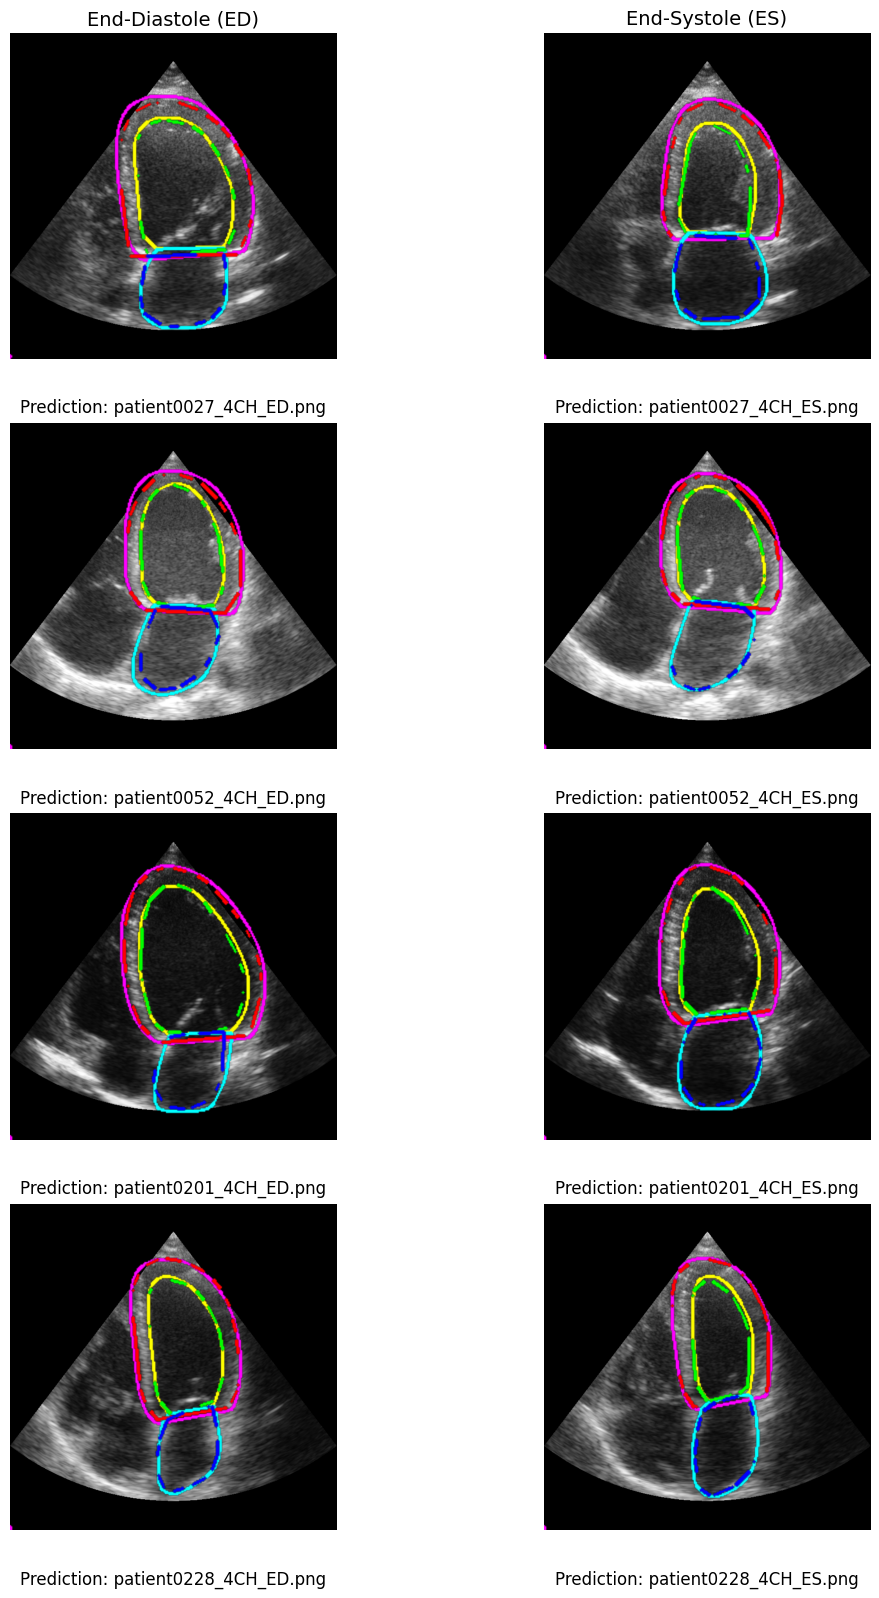

In [29]:
########################################
# Visualization of Predictions         #
########################################
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch
import os

# Updated colormap for predictions
pred_colors = {
    1: (255, 255, 0),  # Class 1 (yellow)
    2: (255, 0, 255),  # Class 2 (magenta)
    3: (0, 255, 255)   # Class 3 (cyan)
}

# Original colormap for ground truth
gt_colors = {
    1: (0, 255, 0),    # Class 1 (green)
    2: (255, 0, 0),    # Class 2 (red)
    3: (0, 0, 255)     # Class 3 (blue)
}

def create_solid_contours(mask, class_colors, thickness=2, alpha=1):
    """Create solid contours for predictions."""
    mask_solid = np.zeros((*mask.shape, 4), dtype=np.uint8)

    for c, color in class_colors.items():
        binary_mask = (mask == c).astype(np.uint8)
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        convex_contours = [cv2.convexHull(cnt) for cnt in contours]
        cv2.drawContours(mask_solid, convex_contours, -1, (*color, int(255 * alpha)), thickness=thickness)

    return mask_solid

def create_hashed_overlay(mask, class_colors, thickness=2, dash_length=2, gap_length=7, alpha=1):
    """Creates a uniform hashed pattern overlay with consistent spacing."""
    mask_hashed = np.zeros((*mask.shape, 4), dtype=np.uint8)

    for c, color in class_colors.items():
        binary_mask = (mask == c).astype(np.uint8)
        # Create a slightly smaller mask to prevent overlap with solid lines
        kernel = np.ones((3,3), np.uint8)
        eroded_mask = cv2.erode(binary_mask, kernel, iterations=1)
        contours, _ = cv2.findContours(eroded_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        convex_contours = [cv2.convexHull(cnt) for cnt in contours]

        for cnt in convex_contours:
            perimeter = cv2.arcLength(cnt, True)
            num_points = int(perimeter / (dash_length + gap_length))
            if num_points < 2:
                continue

            resampled_points = []
            for i in range(num_points):
                dist = (i * perimeter) / num_points
                point = cv2.arcLength(cnt[:int((i/num_points)*len(cnt))], False)
                idx = 0
                curr_dist = 0
                while curr_dist < dist and idx < len(cnt)-1:
                    curr_dist += np.linalg.norm(cnt[idx+1][0] - cnt[idx][0])
                    idx += 1
                resampled_points.append(cnt[idx][0])

            for i in range(0, len(resampled_points)-1, 2):
                pt1 = tuple(resampled_points[i])
                pt2 = tuple(resampled_points[i+1])
                cv2.line(mask_hashed, pt1, pt2, (*color, int(255 * alpha)), thickness)

    return mask_hashed

# Manually specify test images
test_images = [
    "patient0027_4CH_ED.png", "patient0027_4CH_ES.png",
    "patient0052_4CH_ED.png", "patient0052_4CH_ES.png",
    "patient0201_4CH_ED.png", "patient0201_4CH_ES.png",
    "patient0228_4CH_ED.png", "patient0228_4CH_ES.png"
]

# Separate ED and ES images
ed_images = [img for img in test_images if "_ED" in img]
es_images = [img for img in test_images if "_ES" in img]

# Set up subplots: One column for ED and another for ES
num_rows = max(len(ed_images), len(es_images))
fig, axs = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, num_rows * 4))

model.eval()  # Ensure model is in evaluation mode

for row in range(num_rows):
    for col, image_list in enumerate([ed_images, es_images]):
        if row >= len(image_list):
            axs[row, col].axis("off")
            continue

        img_filename = image_list[row]
        img_path = os.path.join(test_images_path, img_filename)

        # Load and process image
        original_image = cv2.imread(img_path)
        original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

        # Get model prediction
        idx = test_dataset.images.index(img_filename)
        image, mask, _ = test_dataset[idx]
        image_batch = image.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(image_batch)
            pred = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

        # Create edge overlays
        pred_solid = create_solid_contours(pred, pred_colors)
        gt_hashed = create_hashed_overlay(mask.cpu().numpy(), gt_colors)

        # Resize masks to match original image
        pred_solid = cv2.resize(pred_solid, (original_image.shape[1], original_image.shape[0]))
        gt_hashed = cv2.resize(gt_hashed, (original_image.shape[1], original_image.shape[0]))

        # Convert original image to RGBA
        result = cv2.cvtColor(original_image, cv2.COLOR_RGB2BGRA)

        # Layer the edges: first predictions (solid), then ground truth (dashed)
        for overlay in [pred_solid, gt_hashed]:
            alpha = overlay[:, :, 3:4].astype(float) / 255
            result = (overlay[:, :, :3] * alpha + result[:, :, :3] * (1 - alpha)).astype(np.uint8)

        # Display result
        axs[row, col].imshow(result)
        axs[row, col].text(
            0.5, -0.15, f"Prediction: {img_filename}", fontsize=12, ha='center', va='center', transform=axs[row, col].transAxes
        )
        axs[row, col].axis("off")

# Add column titles
axs[0, 0].set_title("End-Diastole (ED)", fontsize=14)
axs[0, 1].set_title("End-Systole (ES)", fontsize=14)

plt.tight_layout()
plt.show()

# Draft

## General functions


In [23]:
# Function to compute ASSD for a single class
def compute_assd(pred, target):
    pred_boundary = pred - binary_erosion(pred).astype(float)
    target_boundary = target - binary_erosion(target).astype(float)

    pred_points = np.argwhere(pred_boundary > 0)
    target_points = np.argwhere(target_boundary > 0)

    if len(pred_points) == 0 or len(target_points) == 0:
        return 0  # ASSD is undefined if one of the masks is empty

    distances_pred_to_target = cdist(pred_points, target_points)
    distances_target_to_pred = cdist(target_points, pred_points)

    assd = (np.mean(np.min(distances_pred_to_target, axis=1)) +
            np.mean(np.min(distances_target_to_pred, axis=1))) / 2.0
    return assd

# Function to compute Dice coefficient
def compute_dice(pred, target):
    intersection = (pred * target).sum()
    dice = (2.0 * intersection) / (pred.sum() + target.sum() + 1e-6)
    return dice

# Function to compute IoU (Intersection over Union)
def compute_iou(pred, target):
    intersection = (pred * target).sum()
    union = (pred + target).clip(0, 1).sum()
    iou = intersection / (union + 1e-6)
    return iou

# Function to compute Hausdorff Distance (HD)
def compute_hd(pred, target):
    pred_boundary = pred - binary_erosion(pred).astype(float)
    target_boundary = target - binary_erosion(target).astype(float)

    pred_points = np.argwhere(pred_boundary > 0)
    target_points = np.argwhere(target_boundary > 0)

    if len(pred_points) == 0 or len(target_points) == 0:
        return 0  # HD is undefined if one of the masks is empty

    distances_pred_to_target = cdist(pred_points, target_points)
    distances_target_to_pred = cdist(target_points, pred_points)

    hd_pred_to_target = np.max(np.min(distances_pred_to_target, axis=1))  # max of min distances
    hd_target_to_pred = np.max(np.min(distances_target_to_pred, axis=1))  # max of min distances

    hd = max(hd_pred_to_target, hd_target_to_pred)
    return hd

# Function to compute F1 score
def compute_f1(pred, target):
    tp = (pred * target).sum()  # True positives
    fp = ((pred == 1) & (target == 0)).sum()  # False positives
    fn = ((pred == 0) & (target == 1)).sum()  # False negatives

    if tp + fp + fn == 0:  # Avoid division by zero
        return 0.0

    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
    return f1

## Simple Average Approach


### Test on the whole images


In [24]:
import numpy as np
from scipy.ndimage import binary_erosion
from scipy.spatial.distance import cdist
from tabulate import tabulate

NUM_CLASSES = 4

# Load the best model weights
model.load_state_dict(torch.load(os.path.join(model_path, "best_model.pth"), map_location=device))
model.eval()

###################################################################
# Overall & Per Class Evaluation with dice, IOU, ASSD, HD, and F1 #
###################################################################
iou_per_class = [0.0] * (NUM_CLASSES)
dice_per_class = [0.0] * (NUM_CLASSES)
assd_per_class = [0.0] * (NUM_CLASSES)
hd_per_class = [0.0] * (NUM_CLASSES)
f1_per_class = [0.0] * (NUM_CLASSES)
num_samples = 0

# Initialize accumulators for overall metrics
overall_iou = 0.0
overall_dice = 0.0
overall_assd = 0.0
overall_hd = 0.0
overall_f1 = 0.0

# For loss
num_batches = 0
test_loss = 0.0

with torch.no_grad():
    for images, masks,_ in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)

        loss = criterion(outputs, masks)
        test_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)

        batch_iou = 0.0
        batch_dice = 0.0
        batch_assd = 0.0
        batch_hd = 0.0
        batch_f1 = 0.0

        for i in range(images.size(0)):
            iou_scores = []
            dice_scores = []
            assd_scores = []
            hd_scores = []
            f1_scores = []
            for c in range(1, NUM_CLASSES):  # Exclude background class
                pred_c = (preds[i] == c).float().cpu().numpy()
                target_c = (masks[i] == c).float().cpu().numpy()

                # IoU and Dice
                iou_value = compute_iou(pred_c, target_c)
                iou_scores.append(iou_value)
                iou_per_class[c] += iou_value

                dice_value = compute_dice(pred_c, target_c)
                dice_scores.append(dice_value)
                dice_per_class[c] += dice_value

                # ASSD
                assd_value = compute_assd(pred_c, target_c)
                assd_scores.append(assd_value)
                if assd_value is not None:
                    assd_per_class[c] += assd_value

                # Hausdorff Distance (HD)
                hd_value = compute_hd(pred_c, target_c)
                hd_scores.append(hd_value)
                if hd_value is not None:
                    hd_per_class[c] += hd_value

                # F1 Score
                f1_value = compute_f1(pred_c, target_c)
                f1_scores.append(f1_value)
                f1_per_class[c] += f1_value


            # Compute overall IoU and Dice for this image (excluding background)
            batch_iou += sum(iou_scores) / (NUM_CLASSES - 1)  # Exclude background class
            batch_dice += sum(dice_scores) / (NUM_CLASSES - 1)  # Exclude background class
            batch_assd += sum(assd_scores) / (NUM_CLASSES - 1)  # Exclude background class
            batch_hd += sum(hd_scores) / (NUM_CLASSES - 1)  # Exclude background class
            batch_f1 += sum(f1_scores) / (NUM_CLASSES - 1)  # Exclude background class

            num_samples += 1

        batch_iou /= images.size(0)
        batch_dice /= images.size(0)
        batch_assd /= images.size(0)
        batch_hd /= images.size(0)
        batch_f1 /= images.size(0)

        overall_iou += batch_iou
        overall_dice += batch_dice
        overall_assd += batch_assd
        overall_hd += batch_hd
        overall_f1 += batch_f1
        num_batches += 1

# Compute loss
test_loss /= num_batches

# Compute Overall
overall_iou /= num_batches
overall_dice /= num_batches
overall_assd /= num_batches
overall_hd /= num_batches
overall_f1 /= num_batches

# Normalize metrics per class
iou_per_class = [iou / num_samples for iou in iou_per_class]
dice_per_class = [dice / num_samples for dice in dice_per_class]
assd_per_class = [assd / num_samples for assd in assd_per_class]
hd_per_class = [hd / num_samples for hd in hd_per_class]
f1_per_class = [f1 / num_samples for f1 in f1_per_class]


print("\nTest Results:")
print(f"Test Loss: {test_loss:.4f}\n")

# Define class names
class_names = ["Left Ventricle", "Myocardium", "Left Atrium"]

# Prepare results for overall evaluation and per-class evaluation
overall_results = [
    ["Overall", f"{overall_dice:.3f}", f"{overall_iou:.3f}", f"{overall_assd:.2f}", f"{overall_hd:.1f}", f"{overall_f1:.3f}"]
]

per_class_results = []
for c in range(1, NUM_CLASSES):  # Exclude background class
    per_class_results.append([class_names[c-1],  # Use class names instead of "Class 1", "Class 2", etc.
                              f"{dice_per_class[c]:.3f}",
                              f"{iou_per_class[c]:.3f}",
                              f"{assd_per_class[c]:.2f}",
                              f"{hd_per_class[c]:.1f}",
                              f"{f1_per_class[c]:.3f}"])

# Combine overall and per-class results into one table
combined_results = [
    ["Overall", f"{overall_dice:.3f}", f"{overall_iou:.3f}", f"{overall_assd:.2f}", f"{overall_hd:.1f}", f"{overall_f1:.3f}"]
] + per_class_results

# Table headers
headers = ["Class", "Dice", "IoU", "ASSD", "Hausdorff", "F1 Score"]

# Print the combined table with specific formats for each column
print(tabulate(combined_results, headers=headers, tablefmt="grid", floatfmt=(".3f", ".3f", ".3f", ".2f", ".1f", ".3f")))

<ipython-input-24-93f3761cce8d>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(model_path, "best_model.pth"), map_location=de


Test Results:
Test Loss: 0.1591

+----------------+--------+-------+--------+-------------+------------+
| Class          |   Dice |   IoU |   ASSD |   Hausdorff |   F1 Score |
+================+========+=======+========+=============+============+
| Overall        |  0.921 | 0.856 |   1.92 |        47.3 |      0.921 |
+----------------+--------+-------+--------+-------------+------------+
| Left Ventricle |  0.947 | 0.900 |   1.68 |         5.4 |      0.947 |
+----------------+--------+-------+--------+-------------+------------+
| Myocardium     |  0.890 | 0.804 |   2.17 |       132.6 |      0.890 |
+----------------+--------+-------+--------+-------------+------------+
| Left Atrium    |  0.927 | 0.867 |   1.89 |         5.9 |      0.927 |
+----------------+--------+-------+--------+-------------+------------+


### Test on ED & ES images separatly


In [25]:
import numpy as np
from scipy.ndimage import binary_erosion
from scipy.spatial.distance import cdist
from tabulate import tabulate

NUM_CLASSES = 4

# Load the best model weights
model.load_state_dict(torch.load(os.path.join(model_path, "best_model.pth"), map_location=device))
model.eval()

###################################################################
# Overall & Per Class Evaluation with dice, IOU, ASSD, HD, and F1 #
###################################################################
# Function to evaluate a specific DataLoader
def evaluate(loader, loader_name):
    print(f"Evaluating {loader_name} frames...\n")

    iou_per_class = [0.0] * (NUM_CLASSES)
    dice_per_class = [0.0] * (NUM_CLASSES)
    assd_per_class = [0.0] * (NUM_CLASSES)
    hd_per_class = [0.0] * (NUM_CLASSES)
    f1_per_class = [0.0] * (NUM_CLASSES)
    num_samples = 0

    # Initialize accumulators for overall metrics
    overall_iou = 0.0
    overall_dice = 0.0
    overall_assd = 0.0
    overall_hd = 0.0
    overall_f1 = 0.0

    # For loss
    num_batches = 0
    test_loss = 0.0

    with torch.no_grad():
        for images, masks  in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            loss = criterion(outputs, masks)
            test_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)

            batch_iou = 0.0
            batch_dice = 0.0
            batch_assd = 0.0
            batch_hd = 0.0
            batch_f1 = 0.0

            for i in range(images.size(0)):
                iou_scores = []
                dice_scores = []
                assd_scores = []
                hd_scores = []
                f1_scores = []
                for c in range(1, NUM_CLASSES):  # Exclude background class
                    pred_c = (preds[i] == c).float().cpu().numpy()
                    target_c = (masks[i] == c).float().cpu().numpy()

                    # IoU and Dice
                    iou_value = compute_iou(pred_c, target_c)
                    iou_scores.append(iou_value)
                    iou_per_class[c] += iou_value

                    dice_value = compute_dice(pred_c, target_c)
                    dice_scores.append(dice_value)
                    dice_per_class[c] += dice_value

                    # ASSD
                    assd_value = compute_assd(pred_c, target_c)
                    assd_scores.append(assd_value)
                    if assd_value is not None:
                        assd_per_class[c] += assd_value

                    # Hausdorff Distance (HD)
                    hd_value = compute_hd(pred_c, target_c)
                    hd_scores.append(hd_value)
                    if hd_value is not None:
                        hd_per_class[c] += hd_value

                    # F1 Score
                    f1_value = compute_f1(pred_c, target_c)
                    f1_scores.append(f1_value)
                    f1_per_class[c] += f1_value


                # Compute overall IoU and Dice for this image (excluding background)
                batch_iou += sum(iou_scores) / (NUM_CLASSES - 1)  # Exclude background class
                batch_dice += sum(dice_scores) / (NUM_CLASSES - 1)  # Exclude background class
                batch_assd += sum(assd_scores) / (NUM_CLASSES - 1)  # Exclude background class
                batch_hd += sum(hd_scores) / (NUM_CLASSES - 1)  # Exclude background class
                batch_f1 += sum(f1_scores) / (NUM_CLASSES - 1)  # Exclude background class

                num_samples += 1

            batch_iou /= images.size(0)
            batch_dice /= images.size(0)
            batch_assd /= images.size(0)
            batch_hd /= images.size(0)
            batch_f1 /= images.size(0)

            overall_iou += batch_iou
            overall_dice += batch_dice
            overall_assd += batch_assd
            overall_hd += batch_hd
            overall_f1 += batch_f1
            num_batches += 1

    # Compute loss
    test_loss /= num_batches

    # Compute Overall
    overall_iou /= num_batches
    overall_dice /= num_batches
    overall_assd /= num_batches
    overall_hd /= num_batches
    overall_f1 /= num_batches

    # Normalize metrics per class
    iou_per_class = [iou / num_samples for iou in iou_per_class]
    dice_per_class = [dice / num_samples for dice in dice_per_class]
    assd_per_class = [assd / num_samples for assd in assd_per_class]
    hd_per_class = [hd / num_samples for hd in hd_per_class]
    f1_per_class = [f1 / num_samples for f1 in f1_per_class]


    print("\nTest Results:")
    print(f"Test Loss: {test_loss:.4f}\n")

    # Define class names
    class_names = ["Left Ventricle", "Myocardium", "Left Atrium"]

    # Prepare results for overall evaluation and per-class evaluation
    overall_results = [
        ["Overall", f"{overall_dice:.3f}", f"{overall_iou:.3f}", f"{overall_assd:.2f}", f"{overall_hd:.1f}", f"{overall_f1:.3f}"]
    ]

    per_class_results = []
    for c in range(1, NUM_CLASSES):  # Exclude background class
        per_class_results.append([class_names[c-1],  # Use class names instead of "Class 1", "Class 2", etc.
                                f"{dice_per_class[c]:.3f}",
                                f"{iou_per_class[c]:.3f}",
                                f"{assd_per_class[c]:.2f}",
                                f"{hd_per_class[c]:.1f}",
                                f"{f1_per_class[c]:.3f}"])

    # Combine overall and per-class results into one table
    combined_results = [
        ["Overall", f"{overall_dice:.3f}", f"{overall_iou:.3f}", f"{overall_assd:.2f}", f"{overall_hd:.1f}", f"{overall_f1:.3f}"]
    ] + per_class_results

    # Table headers
    headers = ["Class", "Dice", "IoU", "ASSD", "Hausdorff", "F1 Score"]

    # Print the combined table with specific formats for each column
    print(tabulate(combined_results, headers=headers, tablefmt="grid", floatfmt=(".3f", ".3f", ".3f", ".2f", ".1f", ".3f")))

# Evaluate ED and ES frames separately
evaluate(ed_loader, "ED")
evaluate(es_loader, "ES")

<ipython-input-25-8b13540edad7>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(model_path, "best_model.pth"), map_location=de

Evaluating ED frames...


Test Results:
Test Loss: 0.1617

+----------------+--------+-------+--------+-------------+------------+
| Class          |   Dice |   IoU |   ASSD |   Hausdorff |   F1 Score |
+================+========+=======+========+=============+============+
| Overall        |  0.919 | 0.853 |   1.92 |        47.1 |      0.919 |
+----------------+--------+-------+--------+-------------+------------+
| Left Ventricle |  0.955 | 0.914 |   1.68 |         5.6 |      0.955 |
+----------------+--------+-------+--------+-------------+------------+
| Myocardium     |  0.887 | 0.798 |   2.09 |       129.4 |      0.887 |
+----------------+--------+-------+--------+-------------+------------+
| Left Atrium    |  0.915 | 0.848 |   2.00 |         6.3 |      0.915 |
+----------------+--------+-------+--------+-------------+------------+
Evaluating ES frames...


Test Results:
Test Loss: 0.1542

+----------------+--------+-------+--------+-------------+------------+
| Class          |

## Weighted Average Approach

### Test on the whole images


In [26]:
import numpy as np
from scipy.ndimage import binary_erosion
from scipy.spatial.distance import cdist
from tabulate import tabulate

NUM_CLASSES = 4

# Load the best model weights
model.load_state_dict(torch.load(os.path.join(model_path, "best_model.pth"), map_location=device))
model.eval()

###################################################################
# Overall & Per Class Evaluation with dice, IOU, ASSD, HD, and F1 #
###################################################################
iou_per_class = [0.0] * (NUM_CLASSES)
dice_per_class = [0.0] * (NUM_CLASSES)
assd_per_class = [0.0] * (NUM_CLASSES)
hd_per_class = [0.0] * (NUM_CLASSES)
f1_per_class = [0.0] * (NUM_CLASSES)
num_samples = 0

# Initialize accumulators for overall metrics
overall_iou = 0.0
overall_dice = 0.0
overall_assd = 0.0
overall_hd = 0.0
overall_f1 = 0.0
class_weights = [0.0] * (NUM_CLASSES)  # To calculate class-specific weights

# For Test loss
num_batches = 0
test_loss = 0.0

with torch.no_grad():
    for images, masks,_ in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)

        loss = criterion(outputs, masks)
        test_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)

        for i in range(images.size(0)):
            for c in range(1, NUM_CLASSES):  # Exclude background class
                pred_c = (preds[i] == c).float().cpu().numpy()
                target_c = (masks[i] == c).float().cpu().numpy()

                # IoU and Dice
                iou_value = compute_iou(pred_c, target_c)
                iou_per_class[c] += iou_value

                dice_value = compute_dice(pred_c, target_c)
                dice_per_class[c] += dice_value

                # ASSD
                assd_value = compute_assd(pred_c, target_c)
                if assd_value is not None:
                    assd_per_class[c] += assd_value

                # Hausdorff Distance (HD)
                hd_value = compute_hd(pred_c, target_c)
                if hd_value is not None:
                    hd_per_class[c] += hd_value

                # F1 Score
                f1_value = compute_f1(pred_c, target_c)
                f1_per_class[c] += f1_value

                # Update weights for overall metrics
                class_weight = target_c.sum()  # Total pixels in the ground truth for class c
                class_weights[c] += class_weight
                overall_iou += (iou_value) * class_weight
                overall_dice += (dice_value) * class_weight
                if assd_value is not None:
                    overall_assd += assd_value * class_weight
                if hd_value is not None:
                    overall_hd += hd_value * class_weight
                overall_f1 += f1_value * class_weight

            num_samples += 1

        num_batches += 1

# Compute loss
test_loss /= num_batches

# Normalize metrics per class
iou_per_class = [iou / num_samples for iou in iou_per_class]
dice_per_class = [dice / num_samples for dice in dice_per_class]
assd_per_class = [assd / num_samples for assd in assd_per_class]
hd_per_class = [hd / num_samples for hd in hd_per_class]
f1_per_class = [f1 / num_samples for f1 in f1_per_class]

# Compute overall metrics by weighted average
total_weight = sum(class_weights[1:])  # Exclude background class weight
overall_iou /= total_weight
overall_dice /= total_weight
overall_assd /= total_weight
overall_hd /= total_weight
overall_f1 /= total_weight


print("\nTest Results:")
print(f"Test Loss: {test_loss:.4f}\n")

# Define class names
class_names = ["Left Ventricle", "Myocardium", "Left Atrium"]

# Prepare results for overall evaluation and per-class evaluation
overall_results = [
    ["Overall", f"{overall_dice:.3f}", f"{overall_iou:.3f}", f"{overall_assd:.2f}", f"{overall_hd:.1f}", f"{overall_f1:.3f}"]
]

per_class_results = []
for c in range(1, NUM_CLASSES):  # Exclude background class
    per_class_results.append([class_names[c-1],  # Use class names instead of "Class 1", "Class 2", etc.
                              f"{dice_per_class[c]:.3f}",
                              f"{iou_per_class[c]:.3f}",
                              f"{assd_per_class[c]:.2f}",
                              f"{hd_per_class[c]:.1f}",
                              f"{f1_per_class[c]:.3f}"])

# Combine overall and per-class results into one table
combined_results = [
    ["Overall", f"{overall_dice:.3f}", f"{overall_iou:.3f}", f"{overall_assd:.2f}", f"{overall_hd:.1f}", f"{overall_f1:.3f}"]
] + per_class_results

# Table headers
headers = ["Class", "Dice", "IoU", "ASSD", "Hausdorff", "F1 Score"]

# Print the combined table with specific formats for each column
print(tabulate(combined_results, headers=headers, tablefmt="grid", floatfmt=(".3f", ".3f", ".3f", ".2f", ".1f", ".3f")))

<ipython-input-26-8062ce294e85>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(model_path, "best_model.pth"), map_location=de


Test Results:
Test Loss: 0.1591

+----------------+--------+-------+--------+-------------+------------+
| Class          |   Dice |   IoU |   ASSD |   Hausdorff |   F1 Score |
+================+========+=======+========+=============+============+
| Overall        |  0.923 | 0.860 |   1.97 |        51.9 |      0.923 |
+----------------+--------+-------+--------+-------------+------------+
| Left Ventricle |  0.947 | 0.900 |   1.68 |         5.4 |      0.947 |
+----------------+--------+-------+--------+-------------+------------+
| Myocardium     |  0.890 | 0.804 |   2.17 |       132.6 |      0.890 |
+----------------+--------+-------+--------+-------------+------------+
| Left Atrium    |  0.927 | 0.867 |   1.89 |         5.9 |      0.927 |
+----------------+--------+-------+--------+-------------+------------+


### Test on ED & ES images separatly


In [27]:
import numpy as np
from scipy.ndimage import binary_erosion
from scipy.spatial.distance import cdist
from tabulate import tabulate

NUM_CLASSES = 4

# Load the best model weights
model.load_state_dict(torch.load(os.path.join(model_path, "best_model.pth"), map_location=device))
model.eval()

###################################################################
# Overall & Per Class Evaluation with dice, IOU, ASSD, HD, and F1 #
###################################################################

# Function to evaluate a specific DataLoader
def evaluate(loader, loader_name):
    print(f"Evaluating {loader_name} frames...\n")
    iou_per_class = [0.0] * (NUM_CLASSES)
    dice_per_class = [0.0] * (NUM_CLASSES)
    assd_per_class = [0.0] * (NUM_CLASSES)
    hd_per_class = [0.0] * (NUM_CLASSES)
    f1_per_class = [0.0] * (NUM_CLASSES)
    num_samples = 0

    # Initialize accumulators for overall metrics
    overall_iou = 0.0
    overall_dice = 0.0
    overall_assd = 0.0
    overall_hd = 0.0
    overall_f1 = 0.0
    class_weights = [0.0] * (NUM_CLASSES)  # To calculate class-specific weights

    # For Test loss
    num_batches = 0
    test_loss = 0.0

    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            loss = criterion(outputs, masks)
            test_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)

            for i in range(images.size(0)):
                for c in range(1, NUM_CLASSES):  # Exclude background class
                    pred_c = (preds[i] == c).float().cpu().numpy()
                    target_c = (masks[i] == c).float().cpu().numpy()

                    # IoU and Dice
                    iou_value = compute_iou(pred_c, target_c)
                    iou_per_class[c] += iou_value

                    dice_value = compute_dice(pred_c, target_c)
                    dice_per_class[c] += dice_value

                    # ASSD
                    assd_value = compute_assd(pred_c, target_c)
                    if assd_value is not None:
                        assd_per_class[c] += assd_value

                    # Hausdorff Distance (HD)
                    hd_value = compute_hd(pred_c, target_c)
                    if hd_value is not None:
                        hd_per_class[c] += hd_value

                    # F1 Score
                    f1_value = compute_f1(pred_c, target_c)
                    f1_per_class[c] += f1_value

                    # Update weights for overall metrics
                    class_weight = target_c.sum()  # Total pixels in the ground truth for class c
                    class_weights[c] += class_weight
                    overall_iou += (iou_value) * class_weight
                    overall_dice += (dice_value) * class_weight
                    if assd_value is not None:
                        overall_assd += assd_value * class_weight
                    if hd_value is not None:
                        overall_hd += hd_value * class_weight
                    overall_f1 += f1_value * class_weight

                num_samples += 1

            num_batches += 1

    # Compute loss
    test_loss /= num_batches

    # Normalize metrics per class
    iou_per_class = [iou / num_samples for iou in iou_per_class]
    dice_per_class = [dice / num_samples for dice in dice_per_class]
    assd_per_class = [assd / num_samples for assd in assd_per_class]
    hd_per_class = [hd / num_samples for hd in hd_per_class]
    f1_per_class = [f1 / num_samples for f1 in f1_per_class]

    # Compute overall metrics by weighted average
    total_weight = sum(class_weights[1:])  # Exclude background class weight
    overall_iou /= total_weight
    overall_dice /= total_weight
    overall_assd /= total_weight
    overall_hd /= total_weight
    overall_f1 /= total_weight


    print("\nTest Results:")
    print(f"Test Loss: {test_loss:.4f}\n")

    # Define class names
    class_names = ["Left Ventricle", "Myocardium", "Left Atrium"]

    # Prepare results for overall evaluation and per-class evaluation
    overall_results = [
        ["Overall", f"{overall_dice:.3f}", f"{overall_iou:.3f}", f"{overall_assd:.2f}", f"{overall_hd:.1f}", f"{overall_f1:.3f}"]
    ]

    per_class_results = []
    for c in range(1, NUM_CLASSES):  # Exclude background class
        per_class_results.append([class_names[c-1],  # Use class names instead of "Class 1", "Class 2", etc.
                                f"{dice_per_class[c]:.3f}",
                                f"{iou_per_class[c]:.3f}",
                                f"{assd_per_class[c]:.2f}",
                                f"{hd_per_class[c]:.1f}",
                                f"{f1_per_class[c]:.3f}"])

    # Combine overall and per-class results into one table
    combined_results = [
        ["Overall", f"{overall_dice:.3f}", f"{overall_iou:.3f}", f"{overall_assd:.2f}", f"{overall_hd:.1f}", f"{overall_f1:.3f}"]
    ] + per_class_results

    # Table headers
    headers = ["Class", "Dice", "IoU", "ASSD", "Hausdorff", "F1 Score"]

    # Print the combined table with specific formats for each column
    print(tabulate(combined_results, headers=headers, tablefmt="grid", floatfmt=(".3f", ".3f", ".3f", ".2f", ".1f", ".3f")))

# Evaluate ED and ES frames separately
evaluate(ed_loader, "ED")
evaluate(es_loader, "ES")

<ipython-input-27-abcc296ae0f5>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(model_path, "best_model.pth"), map_location=de

Evaluating ED frames...


Test Results:
Test Loss: 0.1617

+----------------+--------+-------+--------+-------------+------------+
| Class          |   Dice |   IoU |   ASSD |   Hausdorff |   F1 Score |
+================+========+=======+========+=============+============+
| Overall        |  0.923 | 0.861 |   1.97 |        49.3 |      0.923 |
+----------------+--------+-------+--------+-------------+------------+
| Left Ventricle |  0.955 | 0.914 |   1.68 |         5.6 |      0.955 |
+----------------+--------+-------+--------+-------------+------------+
| Myocardium     |  0.887 | 0.798 |   2.09 |       129.4 |      0.887 |
+----------------+--------+-------+--------+-------------+------------+
| Left Atrium    |  0.915 | 0.848 |   2.00 |         6.3 |      0.915 |
+----------------+--------+-------+--------+-------------+------------+
Evaluating ES frames...


Test Results:
Test Loss: 0.1542

+----------------+--------+-------+--------+-------------+------------+
| Class          |